# **Bibliotecas e Funções**

In [1]:
%%capture

!pip install shap
!pip install optuna
!pip install cmaes

In [2]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [4]:
!pip install gdown==4.6.0 --quiet
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [5]:
%%capture

!gdown 129xV7F8XXr_4PqRtcR-GV7unEgNrL6qW --quiet # Sistema Digestório treino
!gdown 13aJGpxw_tAhT-44yuD-mRKjDsJcHwynU --quiet # Sistema Digestório teste

In [6]:
df_sist_dig_treino = pd.read_csv('/content/sist_dig_treino.csv')
print(df_sist_dig_treino.shape)
df_sist_dig_treino.head(3)

(95757, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.855039,-0.487127,0.754328,1.139443,-0.941420,0.659026,-0.310484,0.947846,0.941740,1.192445,...,0.030938,1.236514,0.910933,0.435937,0.471588,0.499958,-0.880861,-0.472869,Boca,0
1,-0.552332,-0.974444,0.882521,-0.739385,-1.035237,1.050825,-0.220933,0.600390,-0.571222,0.737469,...,0.408728,-0.942713,-0.767966,0.798171,0.395082,-0.817516,0.969004,-0.476098,Colorretal,0
2,-1.031751,2.898275,-0.940926,-0.673702,-0.992019,0.061359,-0.373475,-0.522447,0.778654,0.774996,...,0.907689,-0.839215,-1.543551,0.726838,0.741448,0.530647,-1.028309,-0.437315,Orofaringe,0


In [7]:
df_sist_dig_teste = pd.read_csv('/content/sist_dig_teste.csv')
print(df_sist_dig_teste.shape)
df_sist_dig_teste.head(3)

(31922, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,-0.552332,-0.974444,-0.003123,-0.739385,-1.035237,-0.877917,-0.220933,0.600390,-0.571222,-1.355989,...,-0.747934,1.575075,0.652640,0.769895,-0.964587,-0.817516,-1.031988,-0.476098,Colorretal,1
1,-0.651186,-0.487127,-0.937624,1.139443,1.062225,-0.300085,-0.310484,-1.055024,0.941740,1.192445,...,-0.512219,1.963232,1.866126,-0.975263,-1.245632,-0.632483,1.135253,-0.472869,Boca,0
2,1.583661,-0.974444,0.882521,-1.030502,-1.035237,-0.877917,-0.220933,0.600390,-0.571222,-1.355989,...,0.023174,-0.942713,-0.767966,0.798171,4.474089,-0.817516,0.969004,-0.476098,Colorretal,0


In [8]:
# DFs de teste para cada tipo
boca_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Boca']
oro_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Orofaringe']
eso_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Esôfago']
esto_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Estômago']
delg_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Delgado']
colo_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Colorretal']
anus_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Ânus']

boca_teste.shape, oro_teste.shape, eso_teste.shape, esto_teste.shape, delg_teste.shape, colo_teste.shape, anus_teste.shape

((5900, 27),
 (1207, 27),
 (3447, 27),
 (6837, 27),
 (389, 27),
 (13588, 27),
 (554, 27))

# **Sistema Digestório Juntos**

**Sem TOPOGRUP**

## **Pré-processamento**

In [ ]:
# Dados pré-processados
list_drop = ['TOPOGRUP', 'sobrevida_3anos']

# Treino
X_train = df_sist_dig_treino.drop(columns=list_drop).copy()
y_train = df_sist_dig_treino.sobrevida_3anos.copy()

# Teste
X_test = df_sist_dig_teste.drop(columns=list_drop).copy()
y_test = df_sist_dig_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((95757, 25), (95757,), (31922, 25), (31922,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'NENHUM',
       'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS',
       'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS',
       'IBGEATEN', 'HABILIT2', 'ESCOLARI_preench', 'IBGE_idem_IBGEATEN',
       'presenca_rec'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

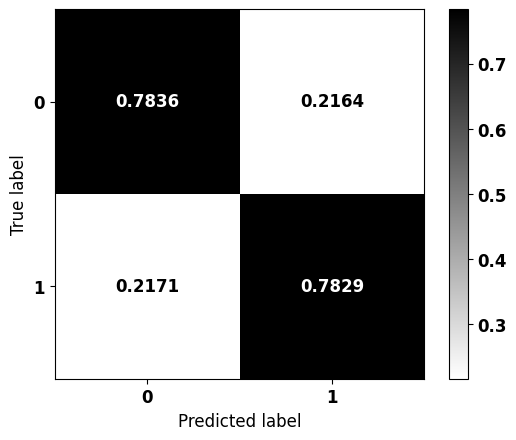


              precision    recall  f1-score   support

           0     0.8426    0.7836    0.8121     19069
           1     0.7092    0.7829    0.7442     12853

    accuracy                         0.7833     31922
   macro avg     0.7759    0.7832    0.7781     31922
weighted avg     0.7889    0.7833    0.7847     31922



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=1.3528,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

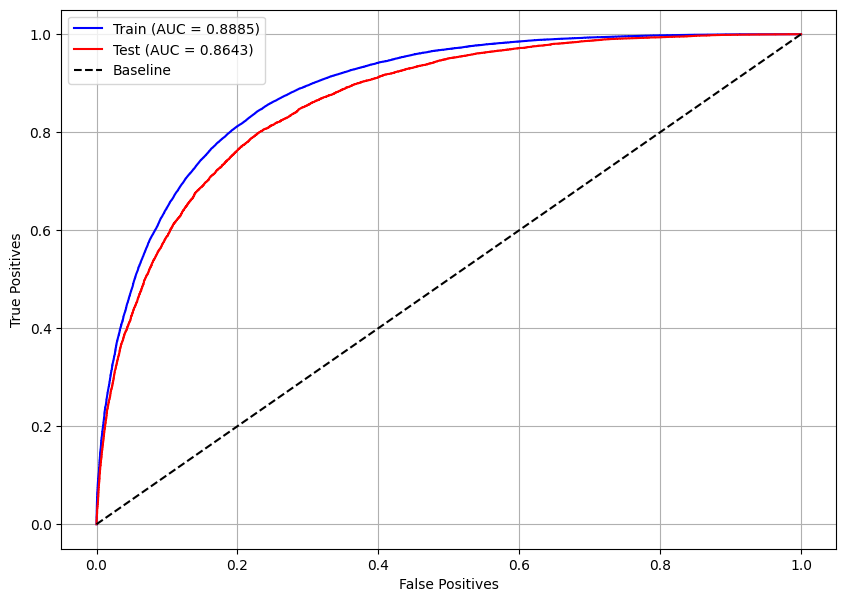

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

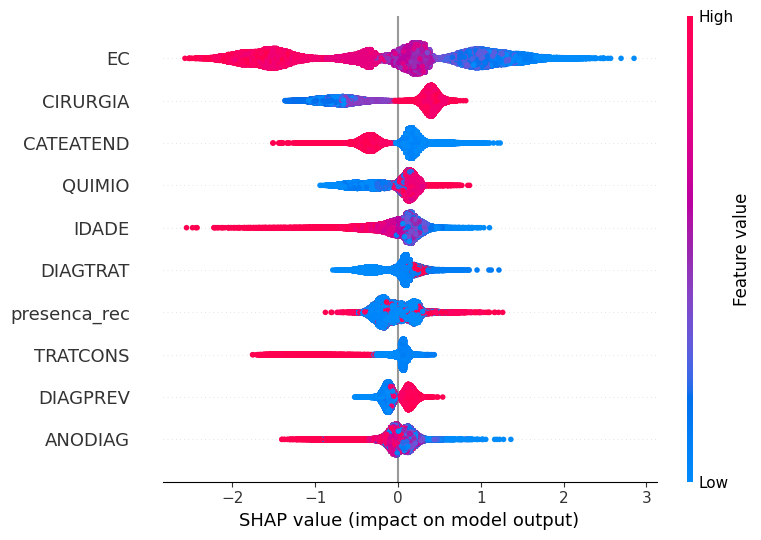

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 136,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.3,
 'min_child_weight': 3,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.34, 1.36, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

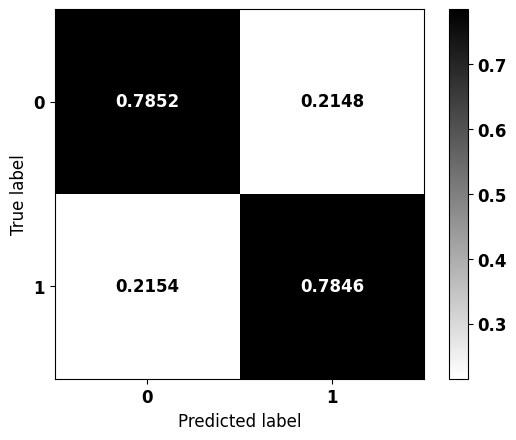


              precision    recall  f1-score   support

           0     0.8439    0.7852    0.8135     19069
           1     0.7111    0.7846    0.7461     12853

    accuracy                         0.7849     31922
   macro avg     0.7775    0.7849    0.7798     31922
weighted avg     0.7905    0.7849    0.7863     31922



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.3414

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

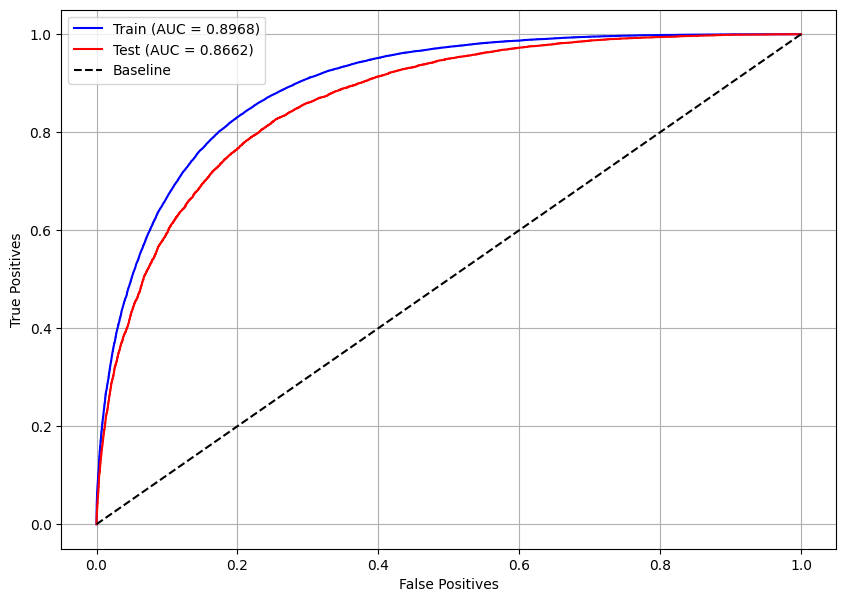

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 103,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 2,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.34, 1.36, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

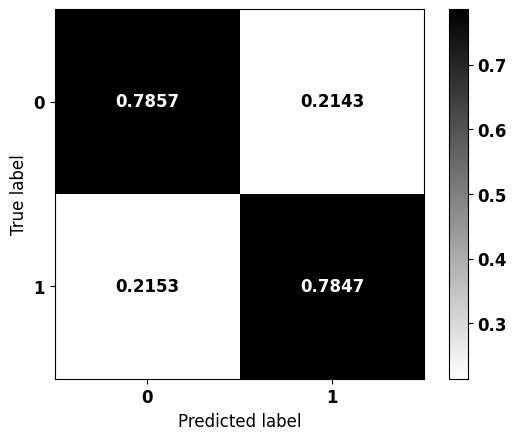


              precision    recall  f1-score   support

           0     0.8441    0.7857    0.8138     19069
           1     0.7116    0.7847    0.7464     12853

    accuracy                         0.7853     31922
   macro avg     0.7779    0.7852    0.7801     31922
weighted avg     0.7908    0.7853    0.7867     31922



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.35

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

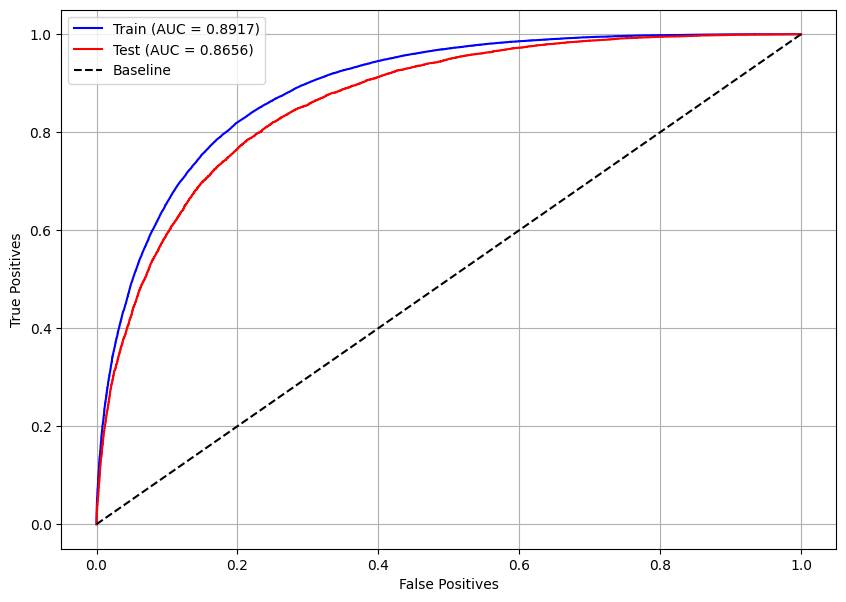

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 105,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 2,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.34, 1.36, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

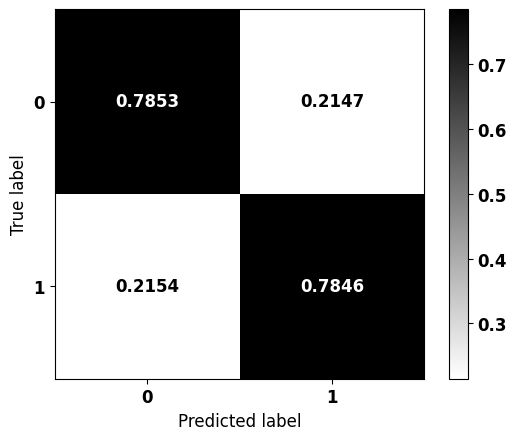


              precision    recall  f1-score   support

           0     0.8439    0.7853    0.8136     19069
           1     0.7112    0.7846    0.7461     12853

    accuracy                         0.7850     31922
   macro avg     0.7776    0.7849    0.7798     31922
weighted avg     0.7905    0.7850    0.7864     31922



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.3498

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

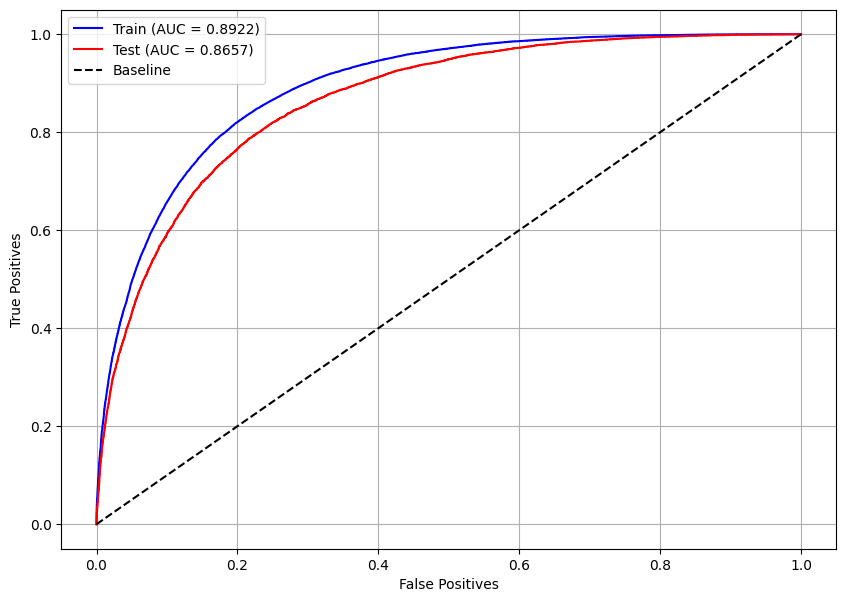

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

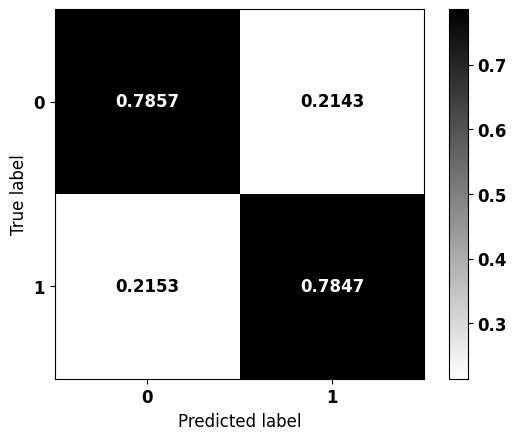


              precision    recall  f1-score   support

           0     0.8441    0.7857    0.8138     19069
           1     0.7116    0.7847    0.7464     12853

    accuracy                         0.7853     31922
   macro avg     0.7779    0.7852    0.7801     31922
weighted avg     0.7908    0.7853    0.7867     31922



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 103, 'max_depth': 6, 'learning_rate': 0.2,
          'gamma': 0.2, 'min_child_weight': 2, 'colsample_bytree': 0.6}

params['random_state'] = seed
params['scale_pos_weight'] = 1.35

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

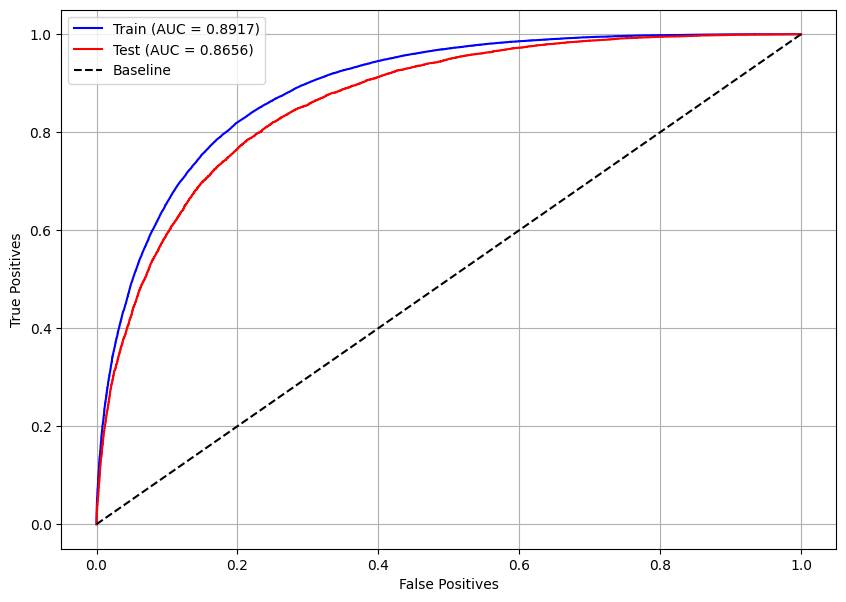

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

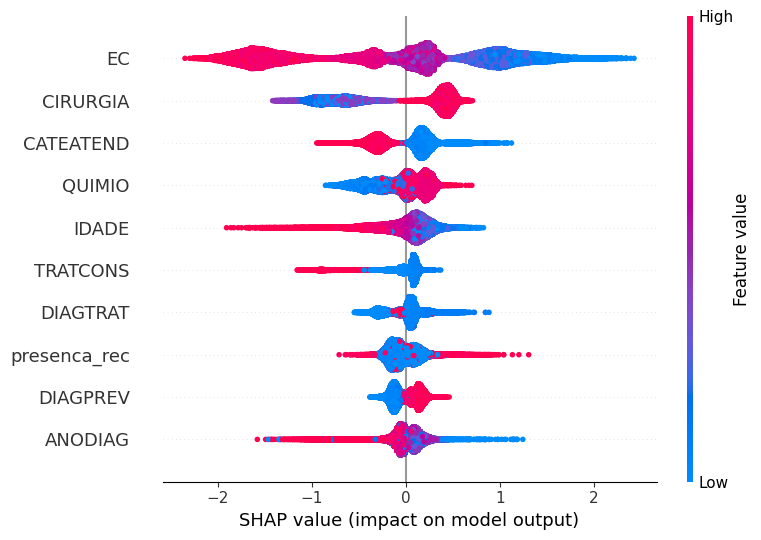

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

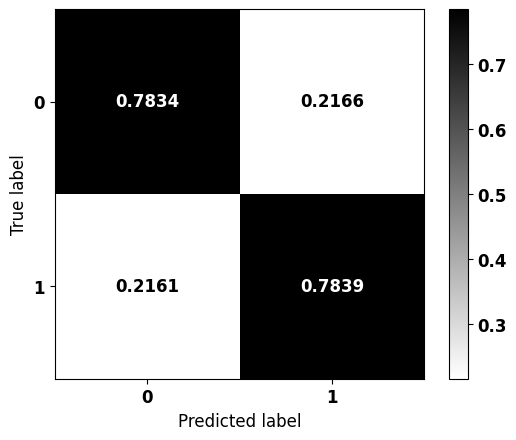


              precision    recall  f1-score   support

           0     0.8432    0.7834    0.8122     19069
           1     0.7093    0.7839    0.7447     12853

    accuracy                         0.7836     31922
   macro avg     0.7762    0.7836    0.7785     31922
weighted avg     0.7893    0.7836    0.7850     31922



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1, 1:1.32},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

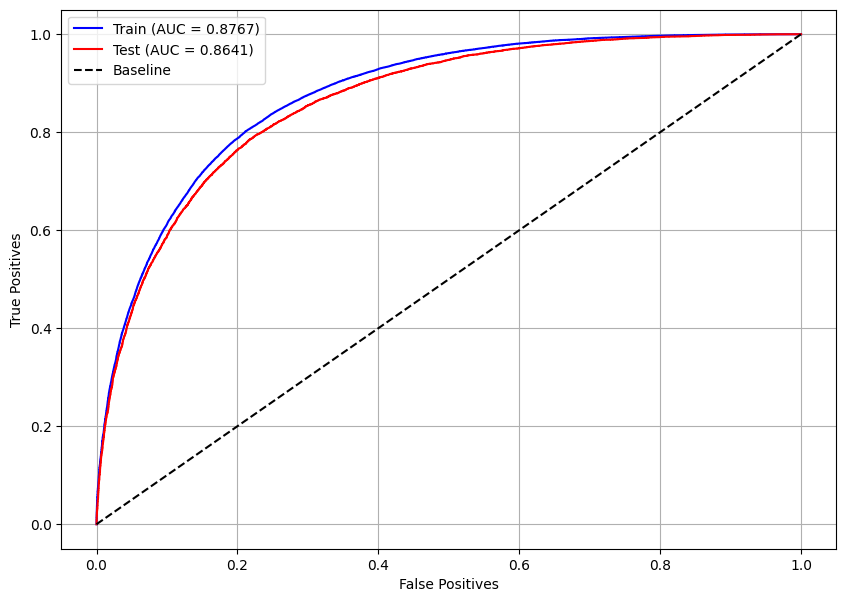

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

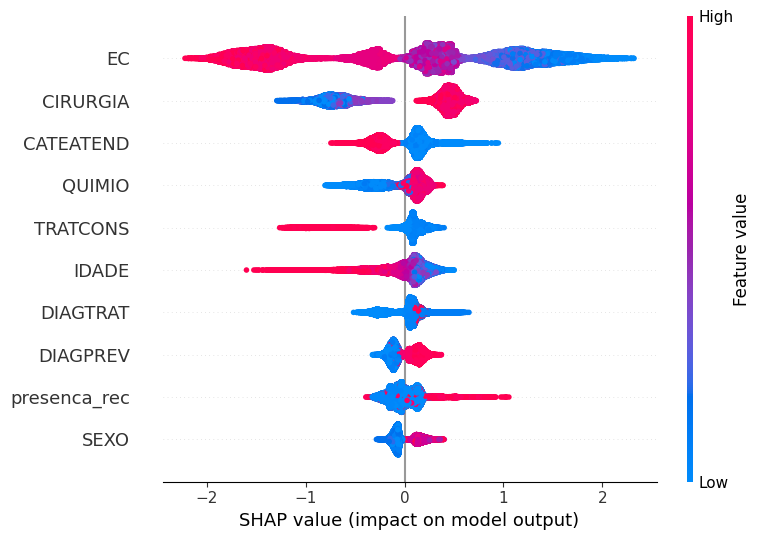

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 134,
 'max_depth': 9,
 'learning_rate': 0.19,
 'min_child_weight': 5,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.35, 1.36, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

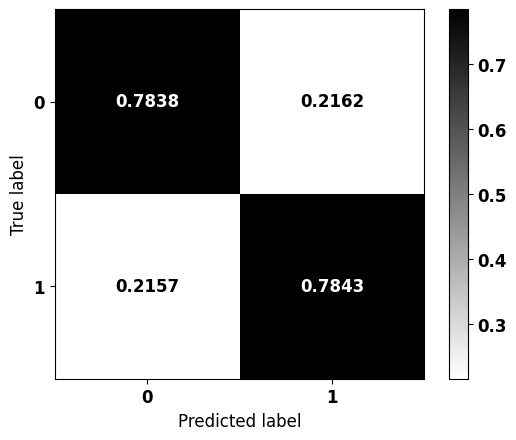


              precision    recall  f1-score   support

           0     0.8435    0.7838    0.8126     19069
           1     0.7098    0.7843    0.7451     12853

    accuracy                         0.7840     31922
   macro avg     0.7766    0.7840    0.7789     31922
weighted avg     0.7897    0.7840    0.7854     31922



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.3525}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

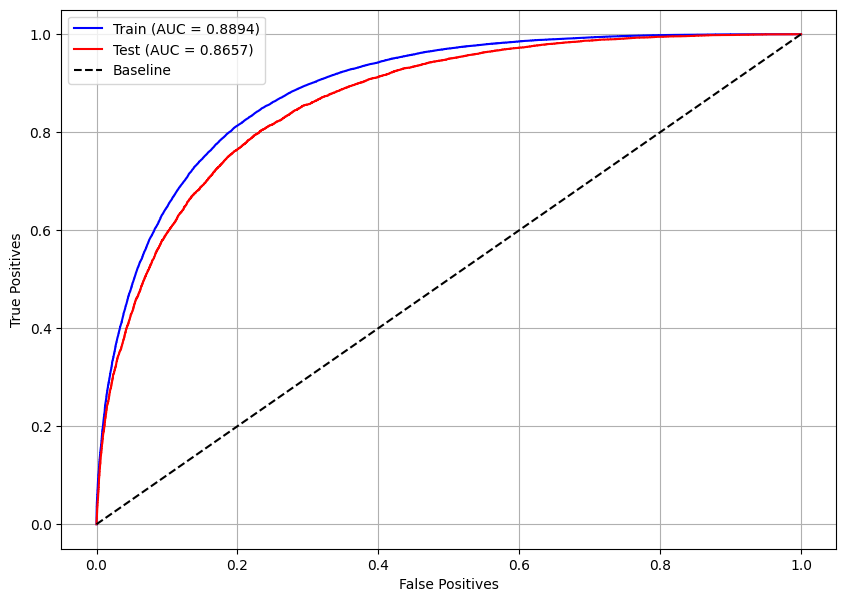

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 129,
 'max_depth': 9,
 'learning_rate': 0.13,
 'min_child_weight': 6,
 'colsample_bytree': 0.3}

In [ ]:
pesos = np.round(np.arange(1.35, 1.36, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

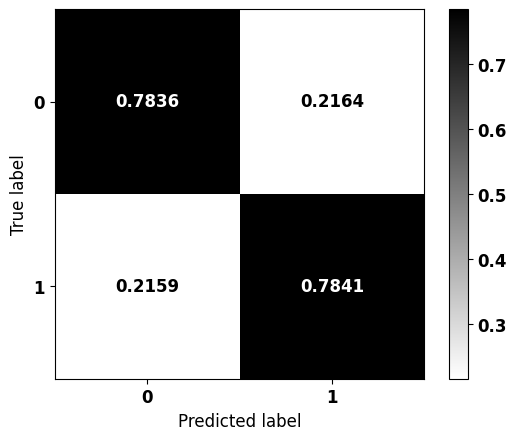


              precision    recall  f1-score   support

           0     0.8434    0.7836    0.8124     19069
           1     0.7095    0.7841    0.7449     12853

    accuracy                         0.7838     31922
   macro avg     0.7764    0.7839    0.7787     31922
weighted avg     0.7895    0.7838    0.7852     31922



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.3509}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

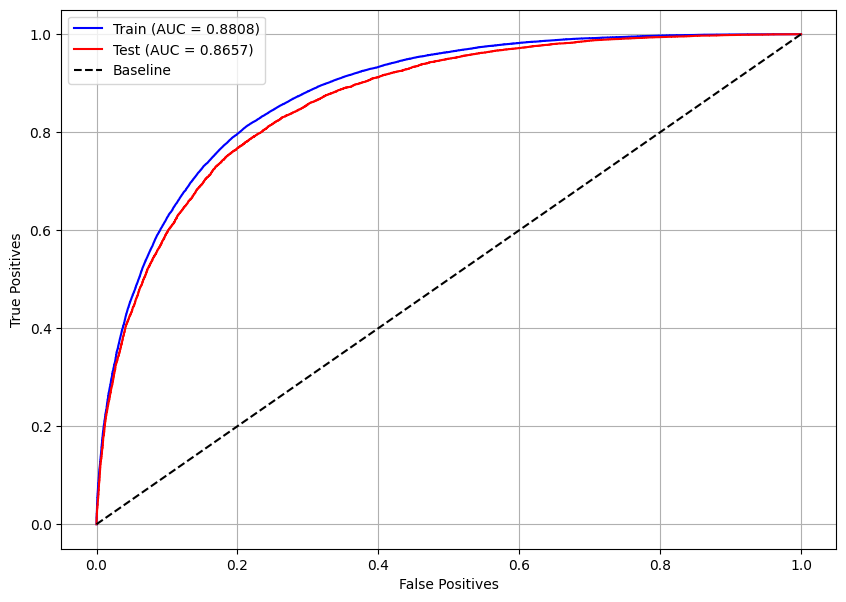

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 113,
 'max_depth': 9,
 'learning_rate': 0.16,
 'min_child_weight': 4,
 'colsample_bytree': 0.3}

In [ ]:
pesos = np.round(np.arange(1.345, 1.36, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

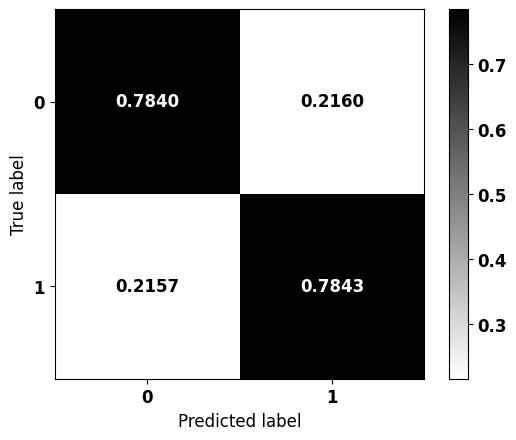


              precision    recall  f1-score   support

           0     0.8436    0.7840    0.8127     19069
           1     0.7099    0.7843    0.7453     12853

    accuracy                         0.7841     31922
   macro avg     0.7768    0.7842    0.7790     31922
weighted avg     0.7898    0.7841    0.7856     31922



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.3454}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

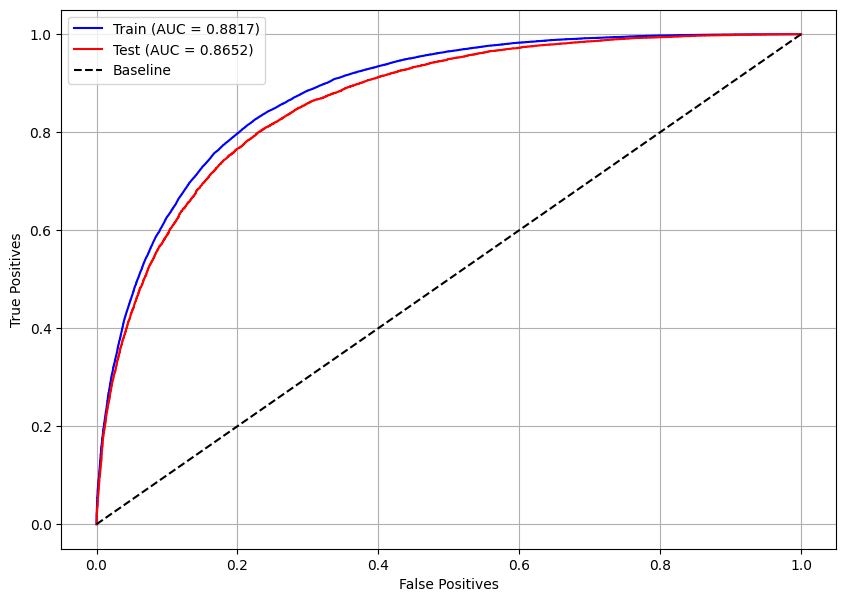

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

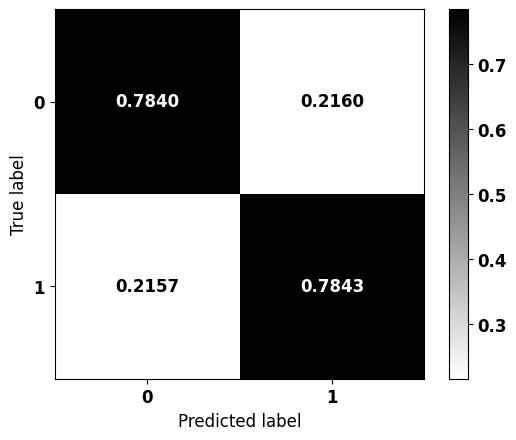


              precision    recall  f1-score   support

           0     0.8436    0.7840    0.8127     19069
           1     0.7099    0.7843    0.7453     12853

    accuracy                         0.7841     31922
   macro avg     0.7768    0.7842    0.7790     31922
weighted avg     0.7898    0.7841    0.7856     31922



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 113, 'max_depth': 9, 'learning_rate': 0.16,
          'min_child_weight': 4, 'colsample_bytree': 0.3}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.3454}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

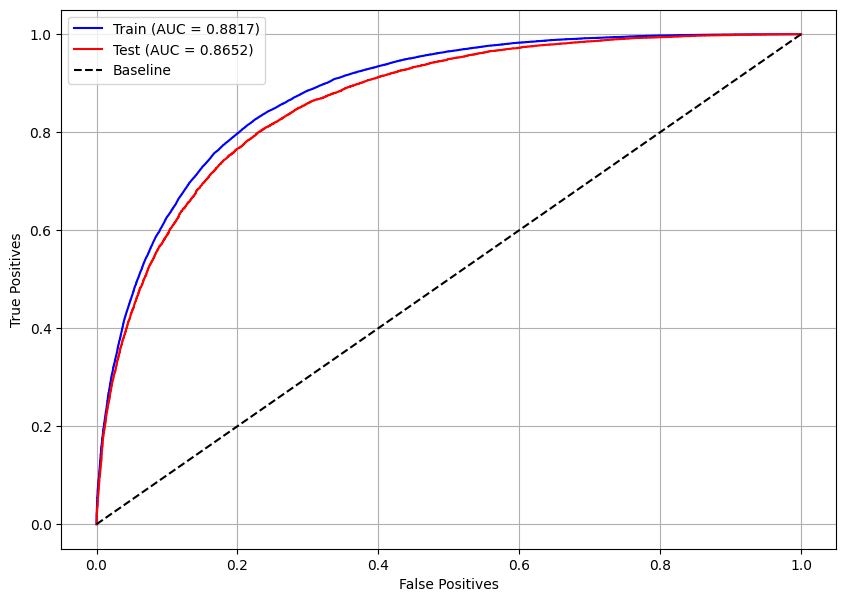

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

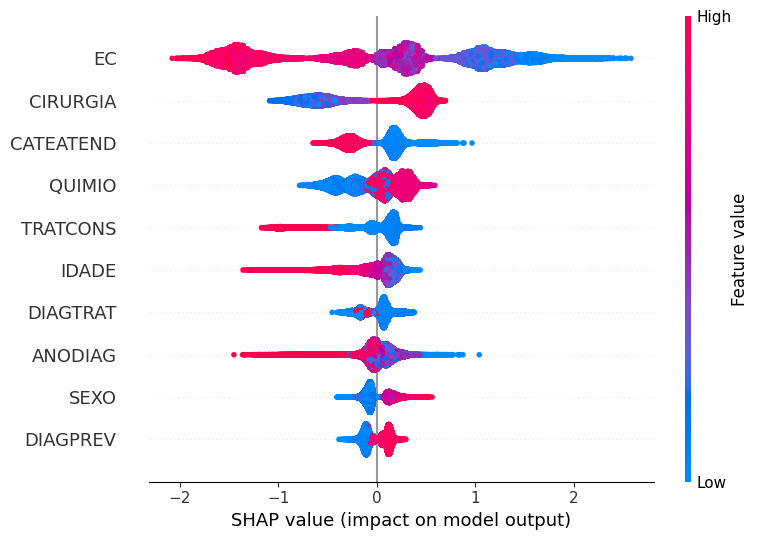

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=103, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


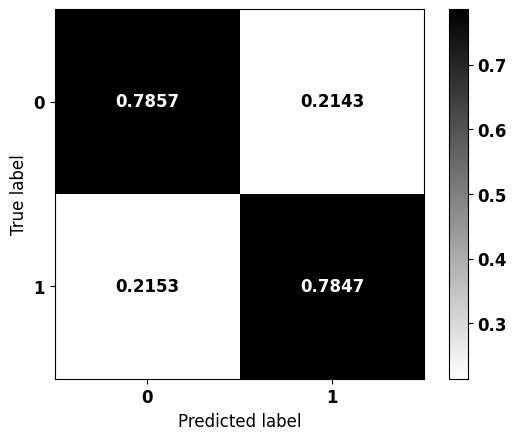


              precision    recall  f1-score   support

           0     0.8441    0.7857    0.8138     19069
           1     0.7116    0.7847    0.7464     12853

    accuracy                         0.7853     31922
   macro avg     0.7779    0.7852    0.7801     31922
weighted avg     0.7908    0.7853    0.7867     31922



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

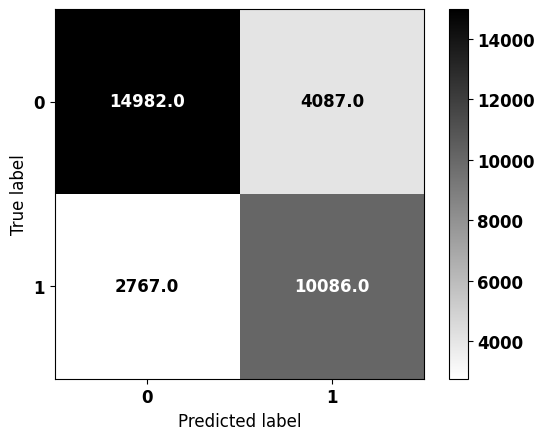


              precision    recall  f1-score   support

           0     0.8441    0.7857    0.8138     19069
           1     0.7116    0.7847    0.7464     12853

    accuracy                         0.7853     31922
   macro avg     0.7779    0.7852    0.7801     31922
weighted avg     0.7908    0.7853    0.7867     31922



In [ ]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

In [ ]:
# Boca
X_test_boca = boca_teste.drop(columns=list_drop).copy()
y_test_boca = boca_teste.sobrevida_3anos.copy()

# Orofaringe
X_test_oro = oro_teste.drop(columns=list_drop).copy()
y_test_oro = oro_teste.sobrevida_3anos.copy()

# Esôfago
X_test_eso = eso_teste.drop(columns=list_drop).copy()
y_test_eso = eso_teste.sobrevida_3anos.copy()

# Estômago
X_test_esto = esto_teste.drop(columns=list_drop).copy()
y_test_esto = esto_teste.sobrevida_3anos.copy()

# Intestino Delgado
X_test_delg = delg_teste.drop(columns=list_drop).copy()
y_test_delg = delg_teste.sobrevida_3anos.copy()

# Colorretal
X_test_colo = colo_teste.drop(columns=list_drop).copy()
y_test_colo = colo_teste.sobrevida_3anos.copy()

# Ânus
X_test_anus = anus_teste.drop(columns=list_drop).copy()
y_test_anus = anus_teste.sobrevida_3anos.copy()

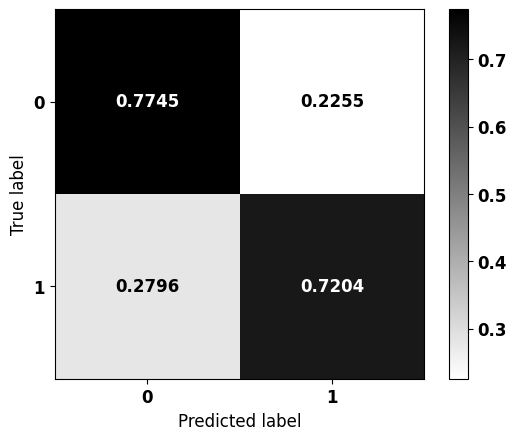


              precision    recall  f1-score   support

           0     0.8020    0.7745    0.7880      3504
           1     0.6860    0.7204    0.7028      2396

    accuracy                         0.7525      5900
   macro avg     0.7440    0.7475    0.7454      5900
weighted avg     0.7549    0.7525    0.7534      5900



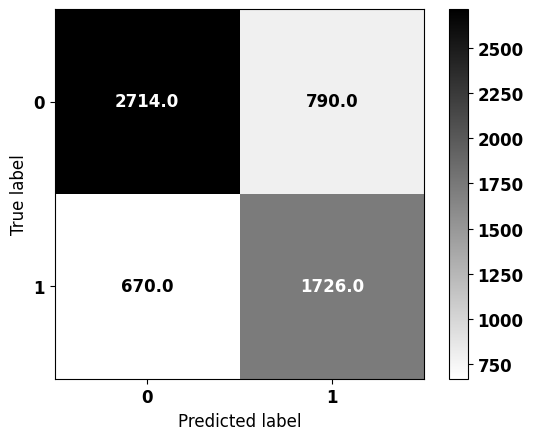


              precision    recall  f1-score   support

           0     0.8020    0.7745    0.7880      3504
           1     0.6860    0.7204    0.7028      2396

    accuracy                         0.7525      5900
   macro avg     0.7440    0.7475    0.7454      5900
weighted avg     0.7549    0.7525    0.7534      5900



In [ ]:
# Boca
plot_confusion_matrix(best, X_test_boca, y_test_boca)
plot_confusion_matrix(best, X_test_boca, y_test_boca, norm=False)

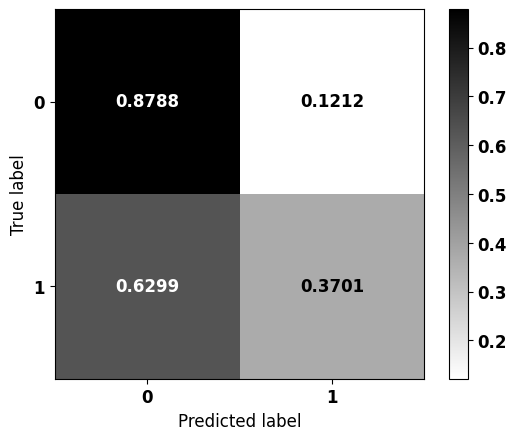


              precision    recall  f1-score   support

           0     0.8028    0.8788    0.8391       899
           1     0.5112    0.3701    0.4294       308

    accuracy                         0.7490      1207
   macro avg     0.6570    0.6244    0.6342      1207
weighted avg     0.7284    0.7490    0.7345      1207



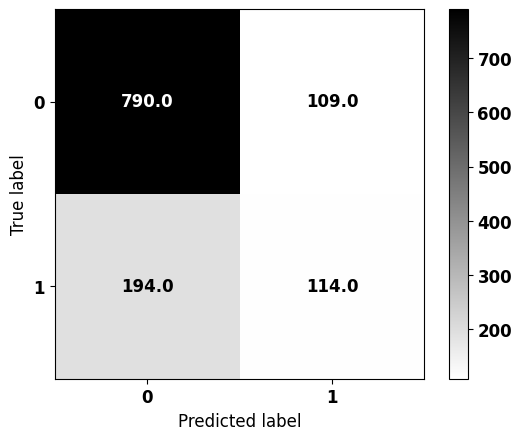


              precision    recall  f1-score   support

           0     0.8028    0.8788    0.8391       899
           1     0.5112    0.3701    0.4294       308

    accuracy                         0.7490      1207
   macro avg     0.6570    0.6244    0.6342      1207
weighted avg     0.7284    0.7490    0.7345      1207



In [ ]:
# Orofaringe
plot_confusion_matrix(best, X_test_oro, y_test_oro)
plot_confusion_matrix(best, X_test_oro, y_test_oro, norm=False)

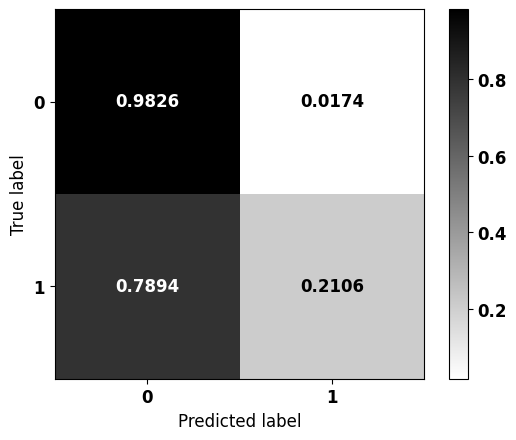


              precision    recall  f1-score   support

           0     0.8921    0.9826    0.9352      2996
           1     0.6463    0.2106    0.3177       451

    accuracy                         0.8816      3447
   macro avg     0.7692    0.5966    0.6265      3447
weighted avg     0.8600    0.8816    0.8544      3447



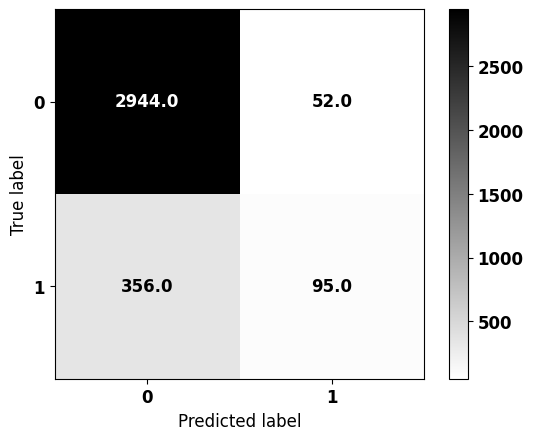


              precision    recall  f1-score   support

           0     0.8921    0.9826    0.9352      2996
           1     0.6463    0.2106    0.3177       451

    accuracy                         0.8816      3447
   macro avg     0.7692    0.5966    0.6265      3447
weighted avg     0.8600    0.8816    0.8544      3447



In [ ]:
# Esôfago
plot_confusion_matrix(best, X_test_eso, y_test_eso)
plot_confusion_matrix(best, X_test_eso, y_test_eso, norm=False)

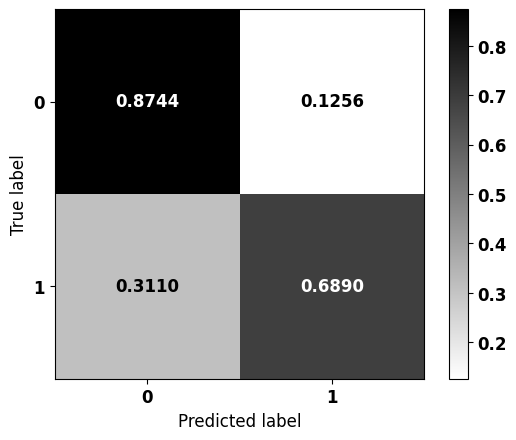


              precision    recall  f1-score   support

           0     0.8855    0.8744    0.8799      5014
           1     0.6660    0.6890    0.6773      1823

    accuracy                         0.8249      6837
   macro avg     0.7757    0.7817    0.7786      6837
weighted avg     0.8269    0.8249    0.8259      6837



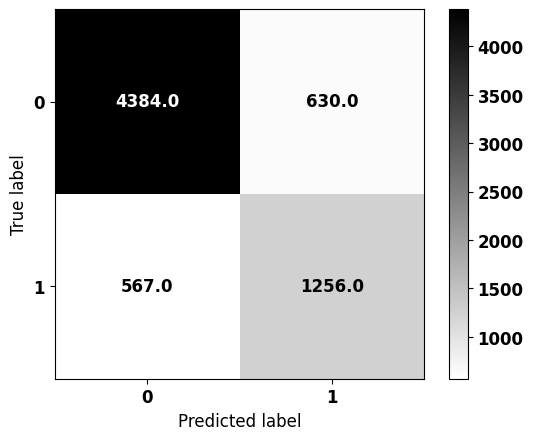


              precision    recall  f1-score   support

           0     0.8855    0.8744    0.8799      5014
           1     0.6660    0.6890    0.6773      1823

    accuracy                         0.8249      6837
   macro avg     0.7757    0.7817    0.7786      6837
weighted avg     0.8269    0.8249    0.8259      6837



In [ ]:
# Estômago
plot_confusion_matrix(best, X_test_esto, y_test_esto)
plot_confusion_matrix(best, X_test_esto, y_test_esto, norm=False)

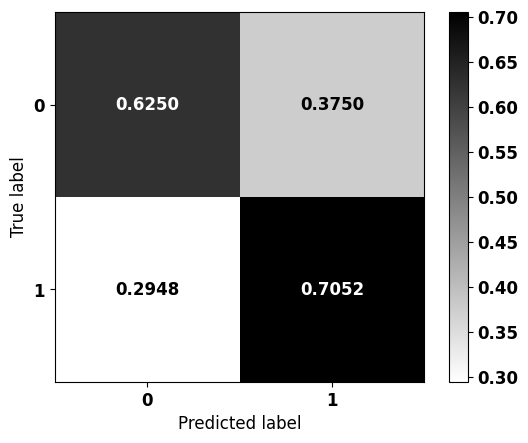


              precision    recall  f1-score   support

           0     0.7258    0.6250    0.6716       216
           1     0.6010    0.7052    0.6489       173

    accuracy                         0.6607       389
   macro avg     0.6634    0.6651    0.6603       389
weighted avg     0.6703    0.6607    0.6615       389



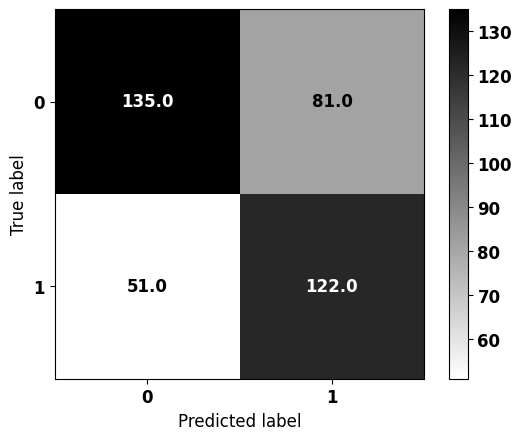


              precision    recall  f1-score   support

           0     0.7258    0.6250    0.6716       216
           1     0.6010    0.7052    0.6489       173

    accuracy                         0.6607       389
   macro avg     0.6634    0.6651    0.6603       389
weighted avg     0.6703    0.6607    0.6615       389



In [ ]:
# Intestino Delgado
plot_confusion_matrix(best, X_test_delg, y_test_delg)
plot_confusion_matrix(best, X_test_delg, y_test_delg, norm=False)

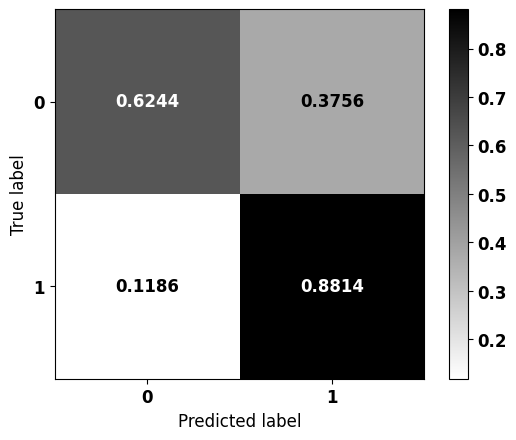


              precision    recall  f1-score   support

           0     0.8147    0.6244    0.7070      6182
           1     0.7376    0.8814    0.8031      7406

    accuracy                         0.7645     13588
   macro avg     0.7762    0.7529    0.7551     13588
weighted avg     0.7727    0.7645    0.7594     13588



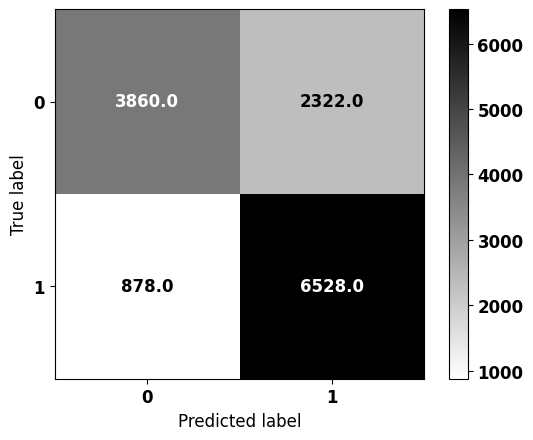


              precision    recall  f1-score   support

           0     0.8147    0.6244    0.7070      6182
           1     0.7376    0.8814    0.8031      7406

    accuracy                         0.7645     13588
   macro avg     0.7762    0.7529    0.7551     13588
weighted avg     0.7727    0.7645    0.7594     13588



In [ ]:
# Colorretal
plot_confusion_matrix(best, X_test_colo, y_test_colo)
plot_confusion_matrix(best, X_test_colo, y_test_colo, norm=False)

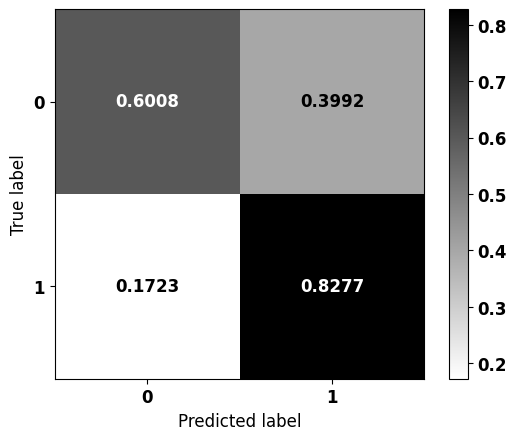


              precision    recall  f1-score   support

           0     0.7524    0.6008    0.6681       258
           1     0.7040    0.8277    0.7609       296

    accuracy                         0.7220       554
   macro avg     0.7282    0.7142    0.7145       554
weighted avg     0.7266    0.7220    0.7177       554



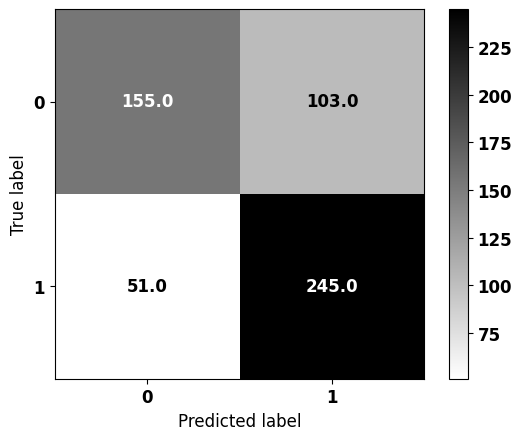


              precision    recall  f1-score   support

           0     0.7524    0.6008    0.6681       258
           1     0.7040    0.8277    0.7609       296

    accuracy                         0.7220       554
   macro avg     0.7282    0.7142    0.7145       554
weighted avg     0.7266    0.7220    0.7177       554



In [ ]:
# Ânus
plot_confusion_matrix(best, X_test_anus, y_test_anus)
plot_confusion_matrix(best, X_test_anus, y_test_anus, norm=False)

### **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7833, Optuna = 0.7853

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7836, Optuna = 0.7841

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1, 1: 1.3454}, colsample_bytree=0.3,
               learning_rate=0.16, max_depth=9, min_child_weight=4,
               n_estimators=113, random_state=7, verbose=-1)

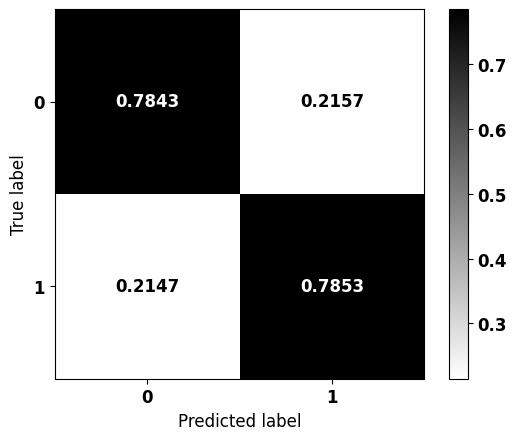


              precision    recall  f1-score   support

           0     0.8443    0.7843    0.8132     19069
           1     0.7105    0.7853    0.7460     12853

    accuracy                         0.7847     31922
   macro avg     0.7774    0.7848    0.7796     31922
weighted avg     0.7904    0.7847    0.7861     31922



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

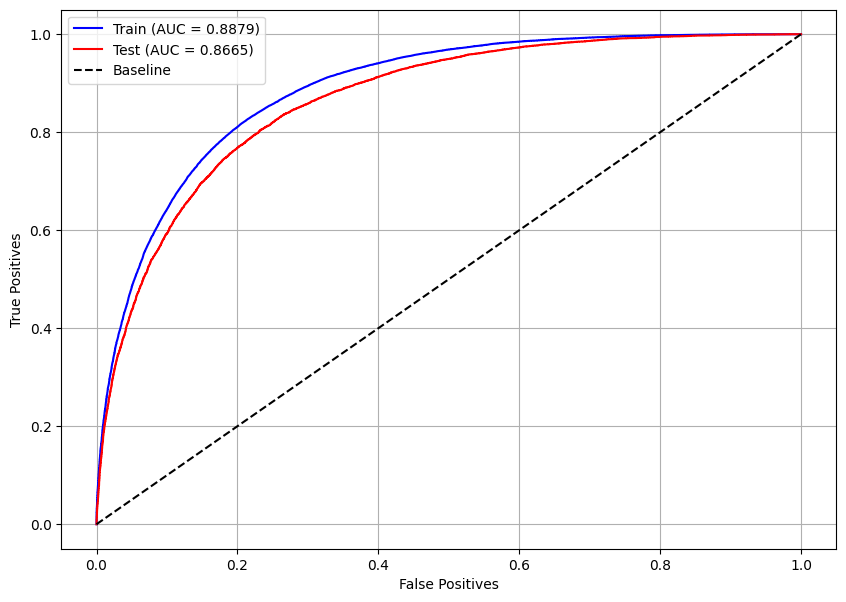

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

# **Sistema Digestório Juntos**

**Com TOPOGRUP**

## **Pré-processamento**

In [9]:
topo = ['Boca', 'Colorretal', 'Orofaringe', 'Esôfago', 'Estômago', 'Ânus', 'Delgado']
num = [0, 1, 2, 3, 4, 5, 6]

df_sist_dig_treino.TOPOGRUP.replace(topo, num, inplace=True)
df_sist_dig_teste.TOPOGRUP.replace(topo, num, inplace=True)

In [10]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df_sist_dig_treino['TOPOGRUP'] = ss.fit_transform(df_sist_dig_treino[['TOPOGRUP']])
df_sist_dig_teste['TOPOGRUP'] = ss.transform(df_sist_dig_teste[['TOPOGRUP']])

In [11]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df_sist_dig_treino.drop(columns=list_drop).copy()
y_train = df_sist_dig_treino.sobrevida_3anos.copy()

# Teste
X_test = df_sist_dig_teste.drop(columns=list_drop).copy()
y_test = df_sist_dig_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((95757, 26), (95757,), (31922, 26), (31922,))

In [12]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'NENHUM',
       'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS',
       'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS',
       'IBGEATEN', 'HABILIT2', 'ESCOLARI_preench', 'IBGE_idem_IBGEATEN',
       'presenca_rec', 'TOPOGRUP'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

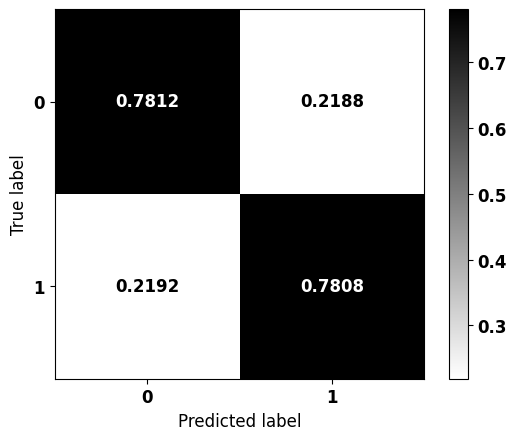


              precision    recall  f1-score   support

           0     0.8410    0.7812    0.8100     19069
           1     0.7064    0.7808    0.7417     12853

    accuracy                         0.7811     31922
   macro avg     0.7737    0.7810    0.7759     31922
weighted avg     0.7868    0.7811    0.7825     31922



In [13]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=1.361,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

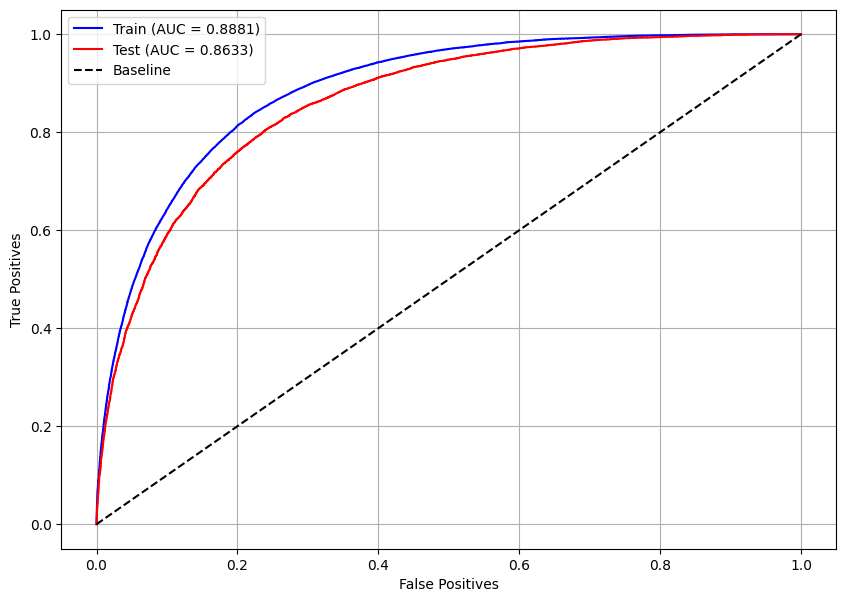

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

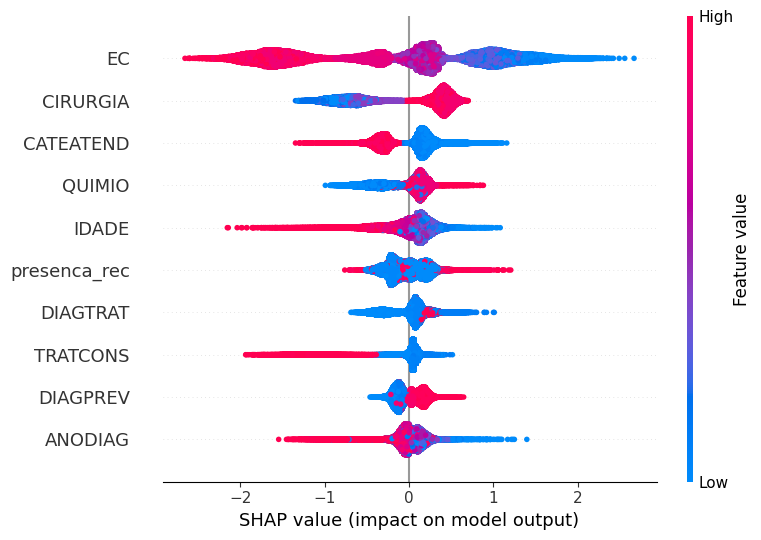

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 130,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 7,
 'colsample_bytree': 0.3}

In [ ]:
pesos = np.round(np.arange(1.335, 1.35, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

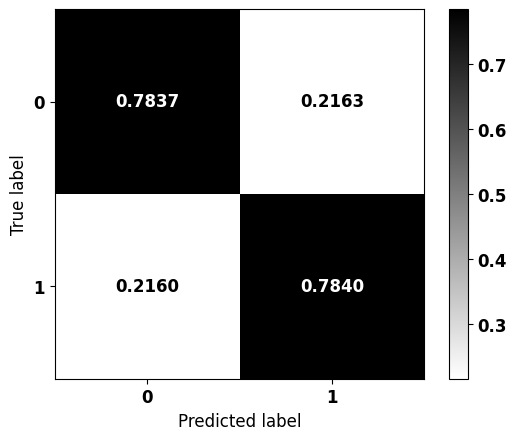


              precision    recall  f1-score   support

           0     0.8433    0.7837    0.8124     19069
           1     0.7095    0.7840    0.7449     12853

    accuracy                         0.7838     31922
   macro avg     0.7764    0.7838    0.7787     31922
weighted avg     0.7895    0.7838    0.7852     31922



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.3372

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

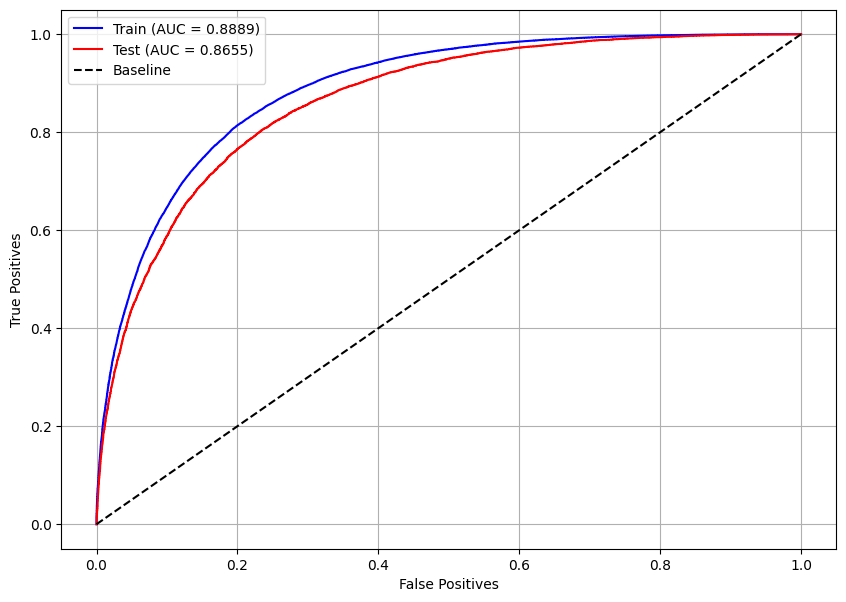

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 130,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.0,
 'min_child_weight': 1,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(1.335, 1.35, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

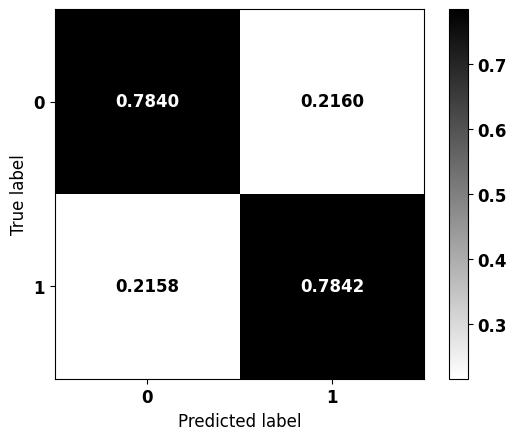


              precision    recall  f1-score   support

           0     0.8435    0.7840    0.8127     19069
           1     0.7099    0.7842    0.7452     12853

    accuracy                         0.7841     31922
   macro avg     0.7767    0.7841    0.7789     31922
weighted avg     0.7897    0.7841    0.7855     31922



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.3477

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

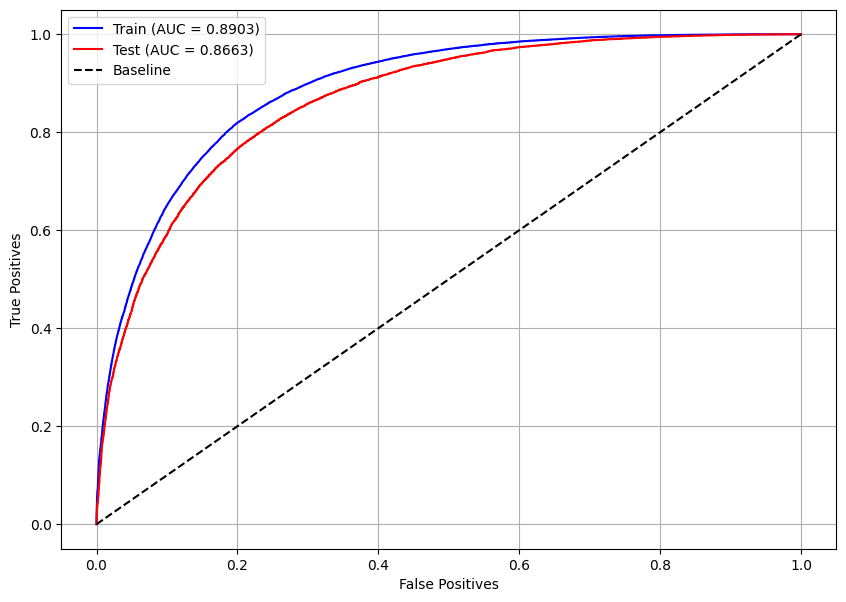

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 140,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 5,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(1.35, 1.36, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

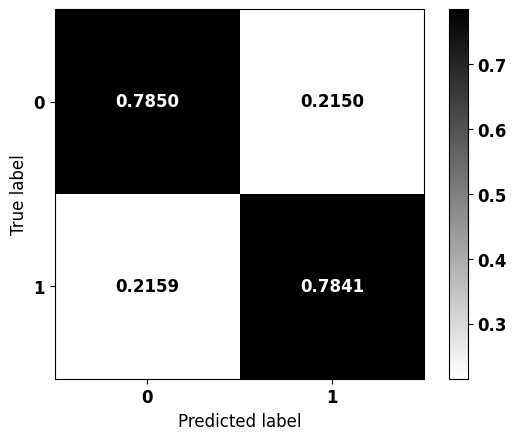


              precision    recall  f1-score   support

           0     0.8436    0.7850    0.8133     19069
           1     0.7109    0.7841    0.7457     12853

    accuracy                         0.7847     31922
   macro avg     0.7772    0.7846    0.7795     31922
weighted avg     0.7902    0.7847    0.7861     31922



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.3493

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

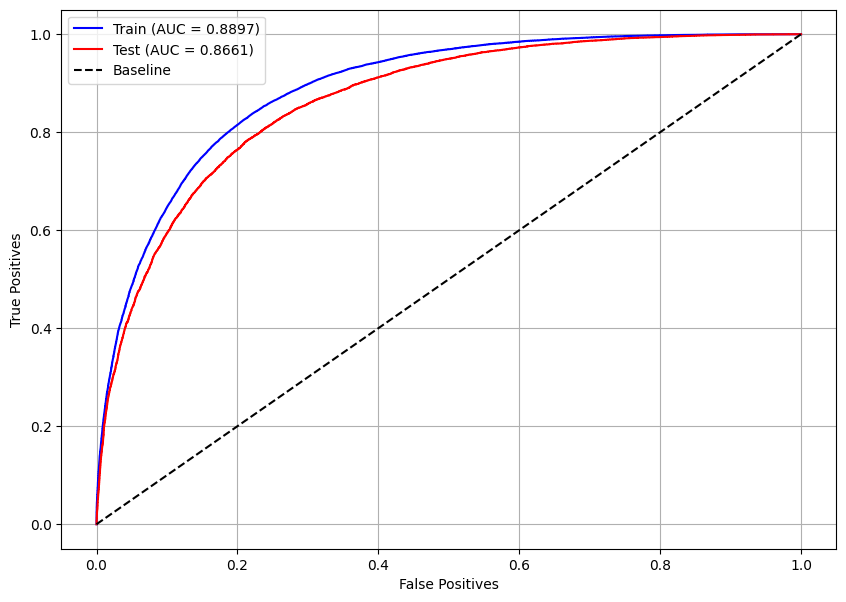

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

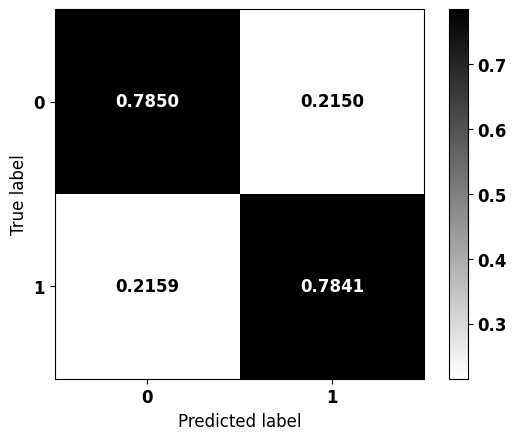


              precision    recall  f1-score   support

           0     0.8436    0.7850    0.8133     19069
           1     0.7109    0.7841    0.7457     12853

    accuracy                         0.7847     31922
   macro avg     0.7772    0.7846    0.7795     31922
weighted avg     0.7902    0.7847    0.7861     31922



In [14]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 140, 'max_depth': 6, 'learning_rate': 0.15,
          'gamma': 0.1, 'min_child_weight': 5, 'colsample_bytree': 0.5}

params['random_state'] = seed
params['scale_pos_weight'] = 1.3493

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

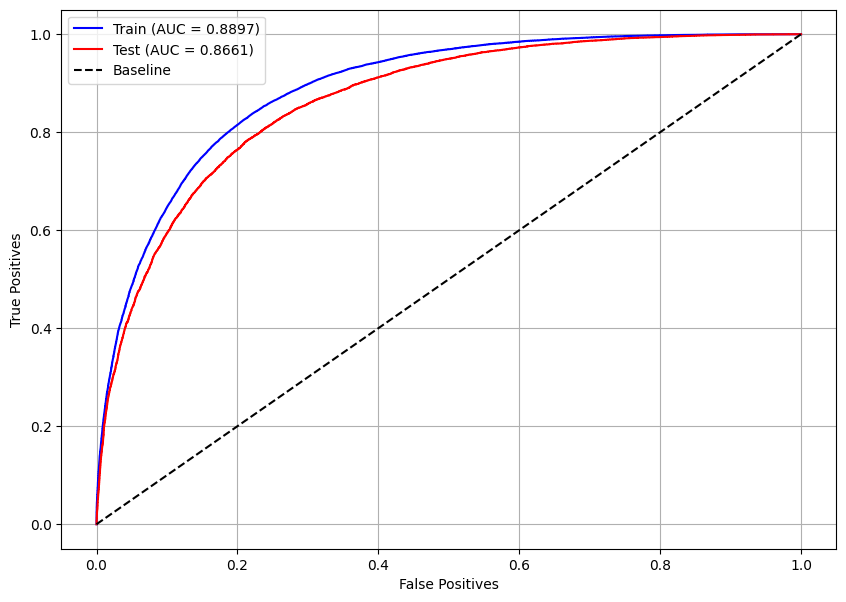

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

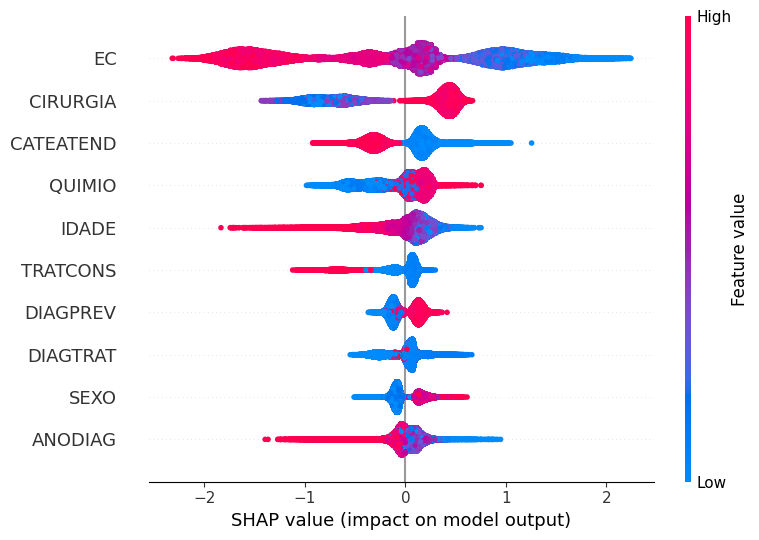

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

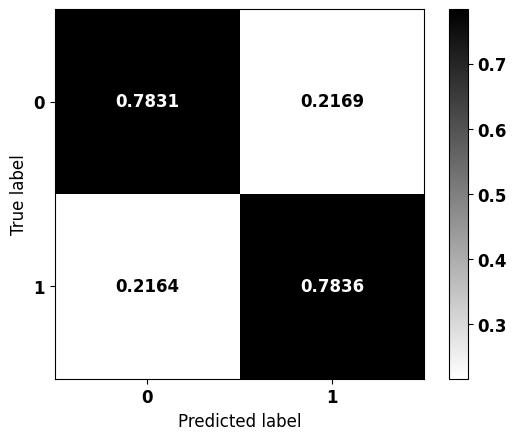


              precision    recall  f1-score   support

           0     0.8429    0.7831    0.8119     19069
           1     0.7088    0.7836    0.7443     12853

    accuracy                         0.7833     31922
   macro avg     0.7759    0.7833    0.7781     31922
weighted avg     0.7889    0.7833    0.7847     31922



In [15]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1, 1:1.33},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

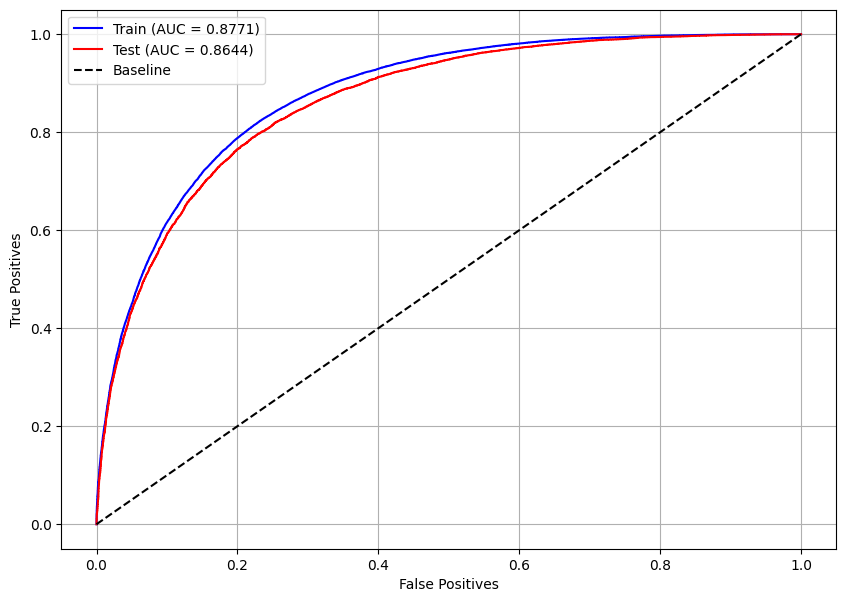

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

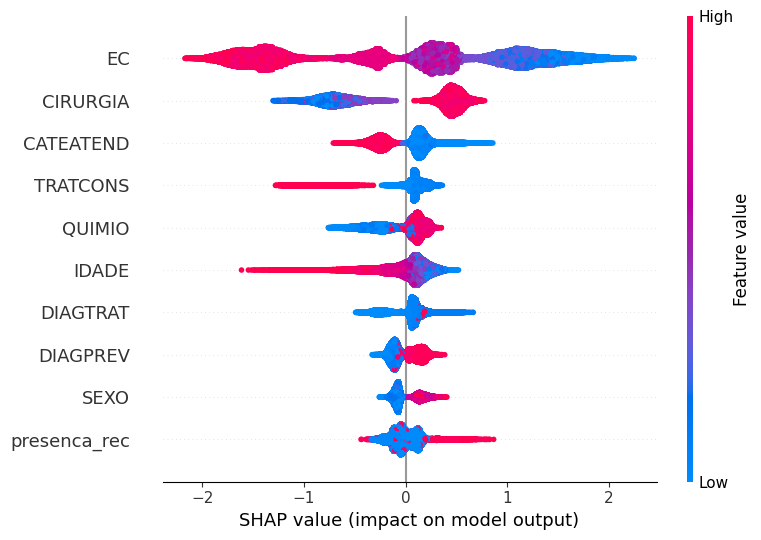

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 144,
 'max_depth': 7,
 'learning_rate': 0.15000000000000002,
 'min_child_weight': 5,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.335, 1.345, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

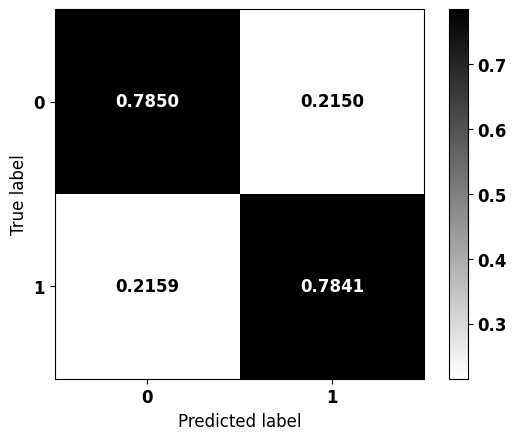


              precision    recall  f1-score   support

           0     0.8436    0.7850    0.8132     19069
           1     0.7108    0.7841    0.7457     12853

    accuracy                         0.7846     31922
   macro avg     0.7772    0.7845    0.7795     31922
weighted avg     0.7901    0.7846    0.7860     31922



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.3438}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

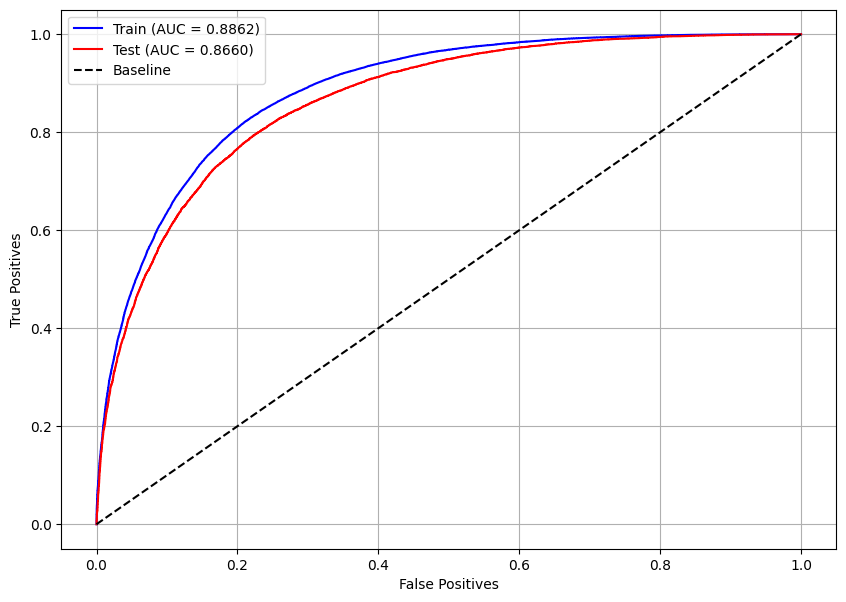

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 102,
 'max_depth': 10,
 'learning_rate': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.335, 1.345, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

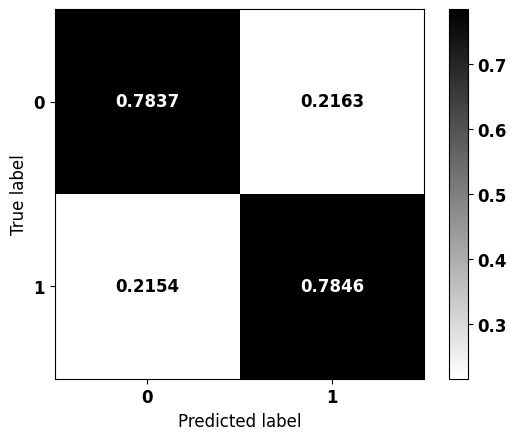


              precision    recall  f1-score   support

           0     0.8437    0.7837    0.8126     19069
           1     0.7097    0.7846    0.7453     12853

    accuracy                         0.7841     31922
   macro avg     0.7767    0.7842    0.7789     31922
weighted avg     0.7898    0.7841    0.7855     31922



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.3422}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

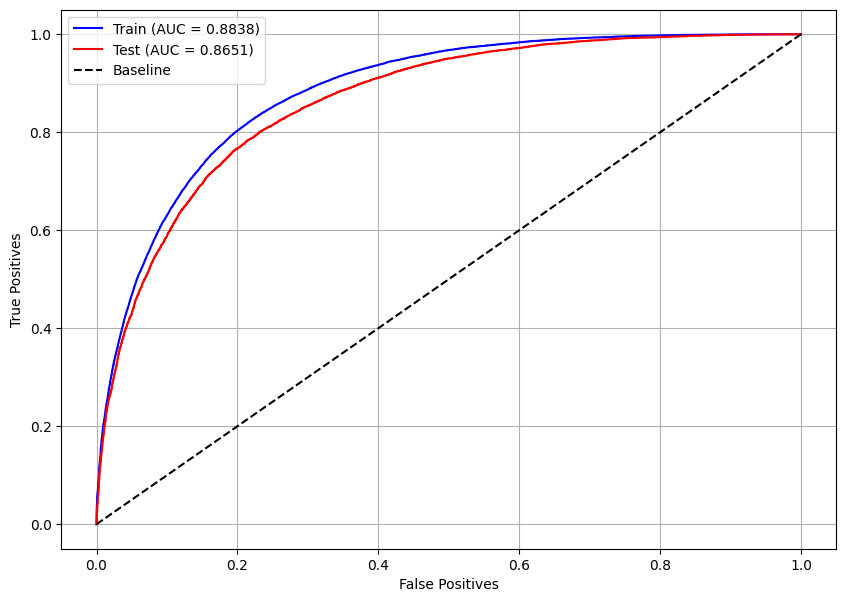

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 146,
 'max_depth': 8,
 'learning_rate': 0.13,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.33, 1.345, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

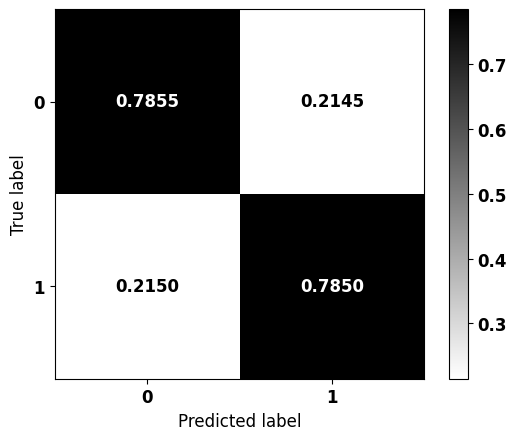


              precision    recall  f1-score   support

           0     0.8443    0.7855    0.8138     19069
           1     0.7115    0.7850    0.7465     12853

    accuracy                         0.7853     31922
   macro avg     0.7779    0.7852    0.7801     31922
weighted avg     0.7908    0.7853    0.7867     31922



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.3348}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

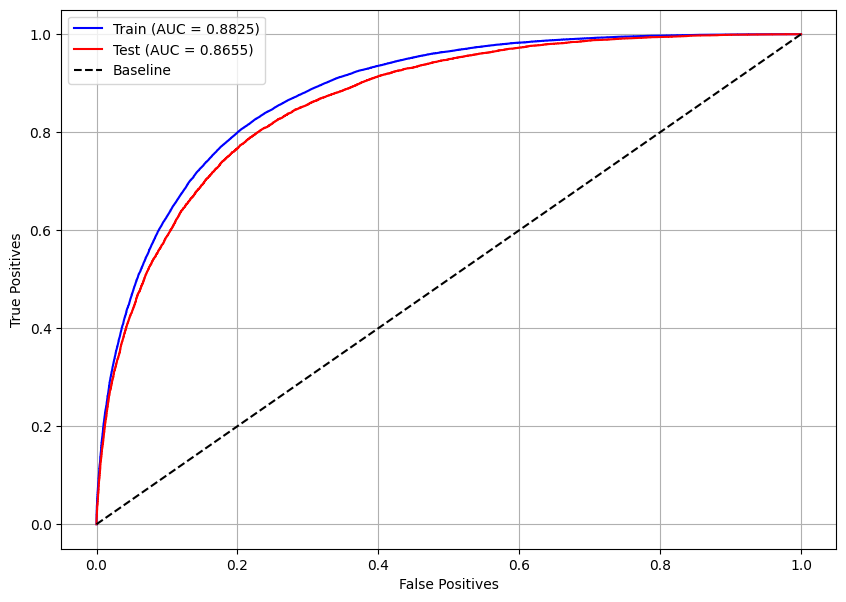

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

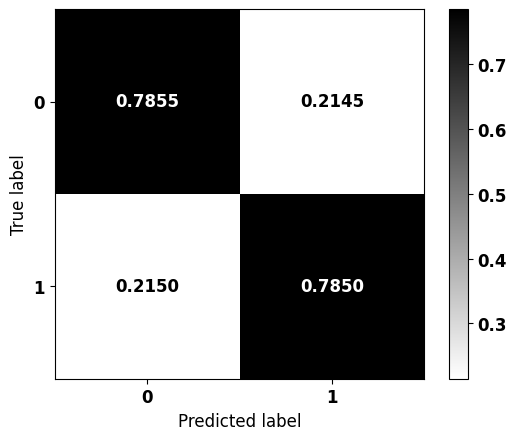


              precision    recall  f1-score   support

           0     0.8443    0.7855    0.8138     19069
           1     0.7115    0.7850    0.7465     12853

    accuracy                         0.7853     31922
   macro avg     0.7779    0.7852    0.7801     31922
weighted avg     0.7908    0.7853    0.7867     31922



In [16]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 146, 'max_depth': 8, 'learning_rate': 0.13,
          'min_child_weight': 5, 'colsample_bytree': 0.4}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.3348}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

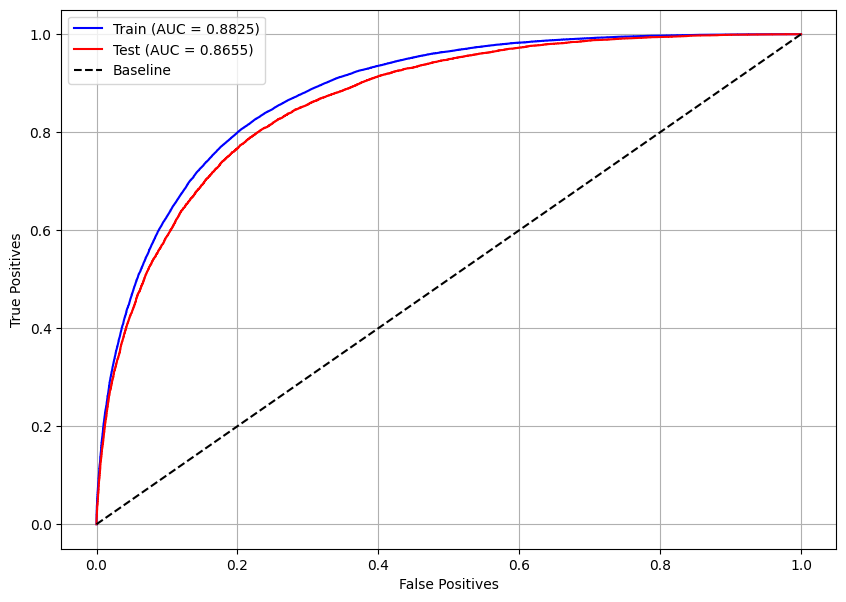

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


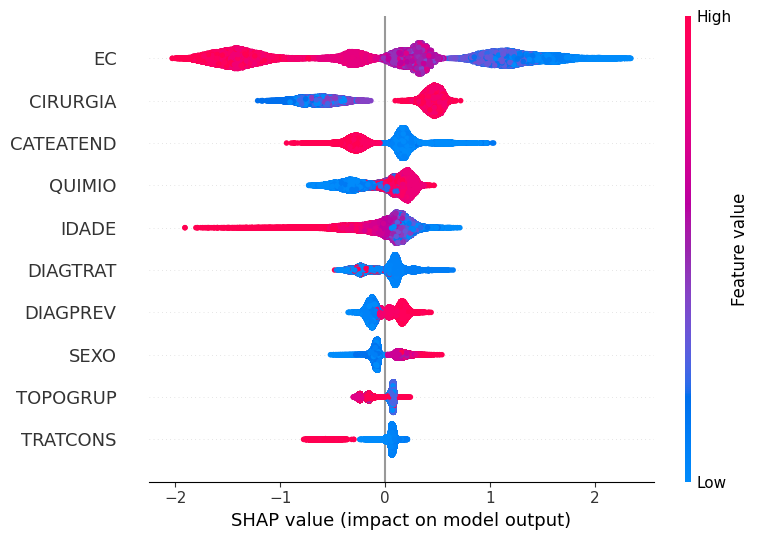

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

### **Testes cruzados**

In [17]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1, 1: 1.3348}, colsample_bytree=0.4,
               learning_rate=0.13, max_depth=8, min_child_weight=5,
               n_estimators=146, random_state=7, verbose=-1)


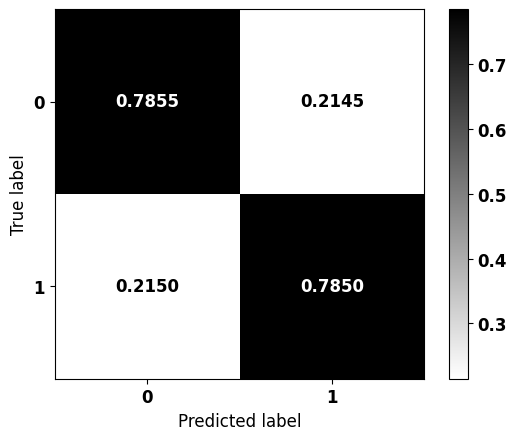


              precision    recall  f1-score   support

           0     0.8443    0.7855    0.8138     19069
           1     0.7115    0.7850    0.7465     12853

    accuracy                         0.7853     31922
   macro avg     0.7779    0.7852    0.7801     31922
weighted avg     0.7908    0.7853    0.7867     31922



In [18]:
plot_confusion_matrix(best, X_test, y_test)

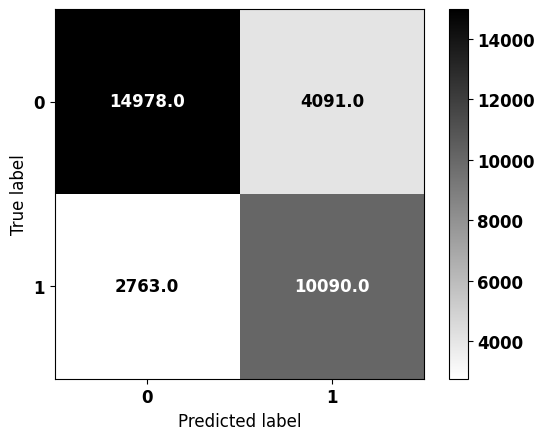


              precision    recall  f1-score   support

           0     0.8443    0.7855    0.8138     19069
           1     0.7115    0.7850    0.7465     12853

    accuracy                         0.7853     31922
   macro avg     0.7779    0.7852    0.7801     31922
weighted avg     0.7908    0.7853    0.7867     31922



In [19]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

In [ ]:
dfs = [boca_teste, colo_teste, oro_teste, eso_teste, esto_teste, anus_teste, delg_teste]

for i, df in enumerate(dfs):
    df.TOPOGRUP.replace(df.TOPOGRUP.unique()[0], i, inplace=True)
    df['TOPOGRUP'] = ss.transform(df[['TOPOGRUP']])

In [21]:
# Boca
X_test_boca = boca_teste.drop(columns=list_drop).copy()
y_test_boca = boca_teste.sobrevida_3anos.copy()

# Orofaringe
X_test_oro = oro_teste.drop(columns=list_drop).copy()
y_test_oro = oro_teste.sobrevida_3anos.copy()

# Esôfago
X_test_eso = eso_teste.drop(columns=list_drop).copy()
y_test_eso = eso_teste.sobrevida_3anos.copy()

# Estômago
X_test_esto = esto_teste.drop(columns=list_drop).copy()
y_test_esto = esto_teste.sobrevida_3anos.copy()

# Intestino Delgado
X_test_delg = delg_teste.drop(columns=list_drop).copy()
y_test_delg = delg_teste.sobrevida_3anos.copy()

# Colorretal
X_test_colo = colo_teste.drop(columns=list_drop).copy()
y_test_colo = colo_teste.sobrevida_3anos.copy()

# Ânus
X_test_anus = anus_teste.drop(columns=list_drop).copy()
y_test_anus = anus_teste.sobrevida_3anos.copy()

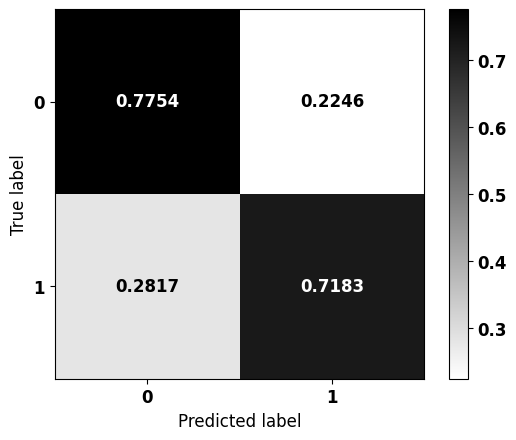


              precision    recall  f1-score   support

           0     0.8010    0.7754    0.7880      3504
           1     0.6862    0.7183    0.7019      2396

    accuracy                         0.7522      5900
   macro avg     0.7436    0.7468    0.7449      5900
weighted avg     0.7544    0.7522    0.7530      5900



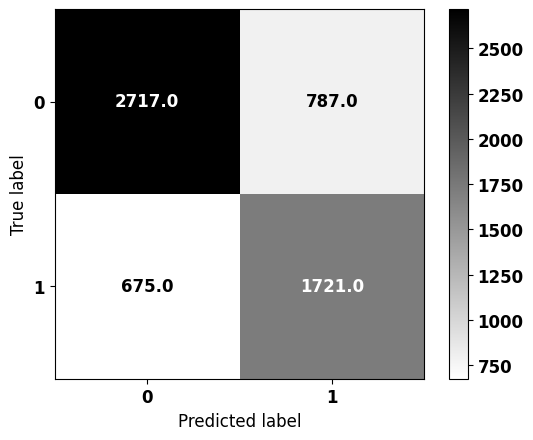


              precision    recall  f1-score   support

           0     0.8010    0.7754    0.7880      3504
           1     0.6862    0.7183    0.7019      2396

    accuracy                         0.7522      5900
   macro avg     0.7436    0.7468    0.7449      5900
weighted avg     0.7544    0.7522    0.7530      5900



In [22]:
# Boca
plot_confusion_matrix(best, X_test_boca, y_test_boca)
plot_confusion_matrix(best, X_test_boca, y_test_boca, norm=False)

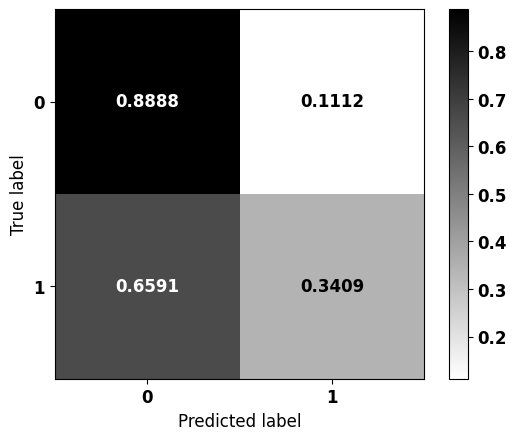


              precision    recall  f1-score   support

           0     0.7974    0.8888    0.8406       899
           1     0.5122    0.3409    0.4094       308

    accuracy                         0.7490      1207
   macro avg     0.6548    0.6148    0.6250      1207
weighted avg     0.7246    0.7490    0.7306      1207



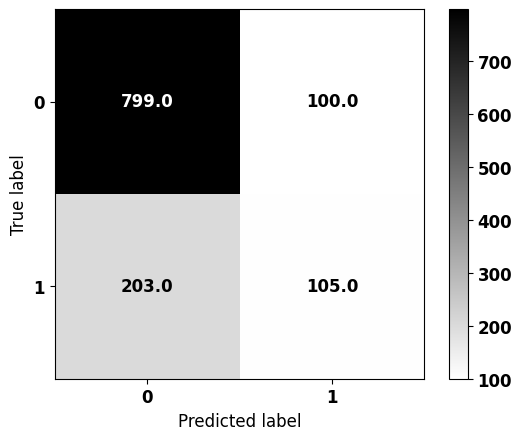


              precision    recall  f1-score   support

           0     0.7974    0.8888    0.8406       899
           1     0.5122    0.3409    0.4094       308

    accuracy                         0.7490      1207
   macro avg     0.6548    0.6148    0.6250      1207
weighted avg     0.7246    0.7490    0.7306      1207



In [23]:
# Orofaringe
plot_confusion_matrix(best, X_test_oro, y_test_oro)
plot_confusion_matrix(best, X_test_oro, y_test_oro, norm=False)

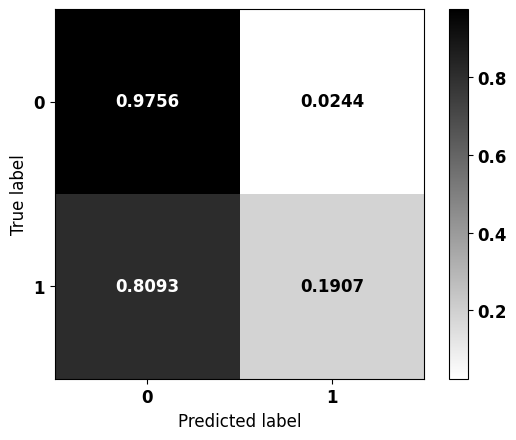


              precision    recall  f1-score   support

           0     0.8890    0.9756    0.9303      2996
           1     0.5409    0.1907    0.2820       451

    accuracy                         0.8729      3447
   macro avg     0.7149    0.5832    0.6061      3447
weighted avg     0.8434    0.8729    0.8455      3447



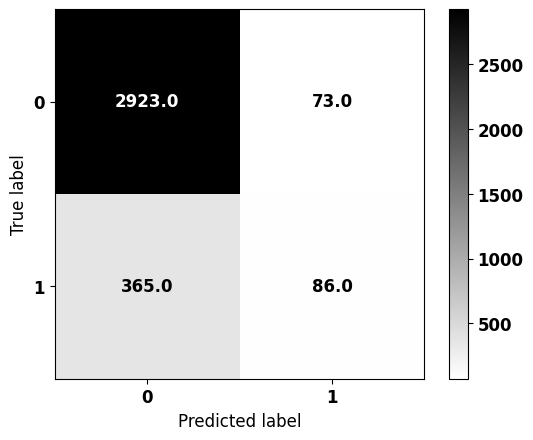


              precision    recall  f1-score   support

           0     0.8890    0.9756    0.9303      2996
           1     0.5409    0.1907    0.2820       451

    accuracy                         0.8729      3447
   macro avg     0.7149    0.5832    0.6061      3447
weighted avg     0.8434    0.8729    0.8455      3447



In [24]:
# Esôfago
plot_confusion_matrix(best, X_test_eso, y_test_eso)
plot_confusion_matrix(best, X_test_eso, y_test_eso, norm=False)

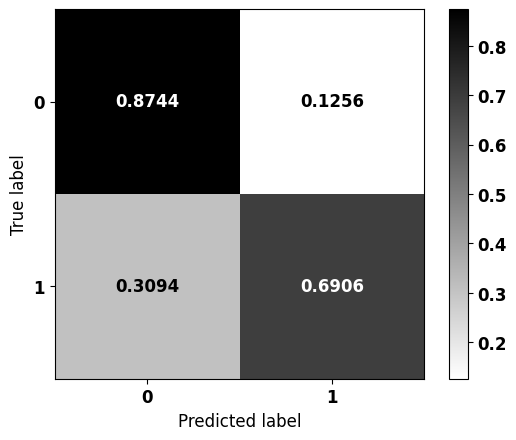


              precision    recall  f1-score   support

           0     0.8860    0.8744    0.8801      5014
           1     0.6665    0.6906    0.6783      1823

    accuracy                         0.8254      6837
   macro avg     0.7763    0.7825    0.7792      6837
weighted avg     0.8275    0.8254    0.8263      6837



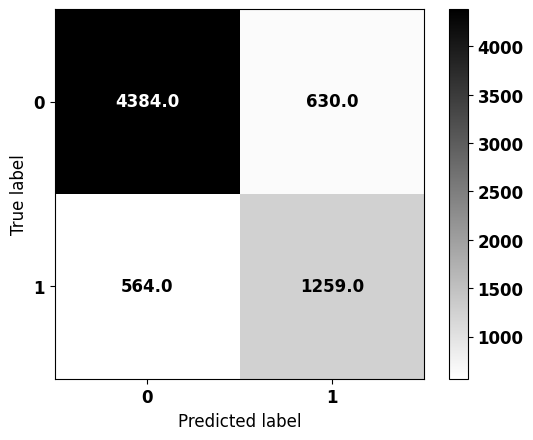


              precision    recall  f1-score   support

           0     0.8860    0.8744    0.8801      5014
           1     0.6665    0.6906    0.6783      1823

    accuracy                         0.8254      6837
   macro avg     0.7763    0.7825    0.7792      6837
weighted avg     0.8275    0.8254    0.8263      6837



In [25]:
# Estômago
plot_confusion_matrix(best, X_test_esto, y_test_esto)
plot_confusion_matrix(best, X_test_esto, y_test_esto, norm=False)

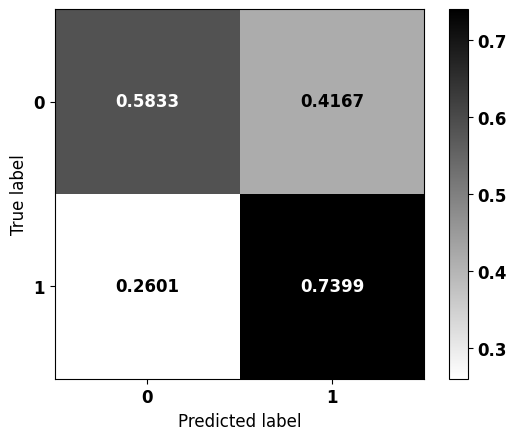


              precision    recall  f1-score   support

           0     0.7368    0.5833    0.6512       216
           1     0.5872    0.7399    0.6547       173

    accuracy                         0.6530       389
   macro avg     0.6620    0.6616    0.6529       389
weighted avg     0.6703    0.6530    0.6527       389



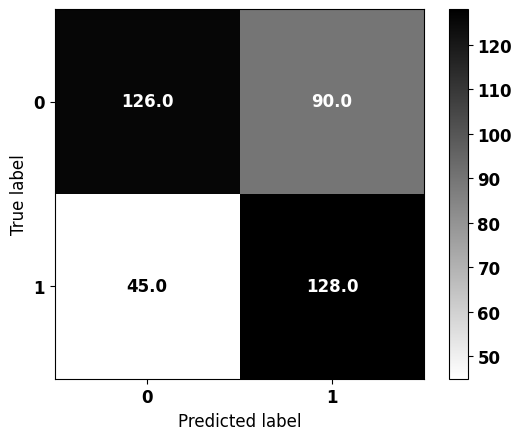


              precision    recall  f1-score   support

           0     0.7368    0.5833    0.6512       216
           1     0.5872    0.7399    0.6547       173

    accuracy                         0.6530       389
   macro avg     0.6620    0.6616    0.6529       389
weighted avg     0.6703    0.6530    0.6527       389



In [26]:
# Intestino Delgado
plot_confusion_matrix(best, X_test_delg, y_test_delg)
plot_confusion_matrix(best, X_test_delg, y_test_delg, norm=False)

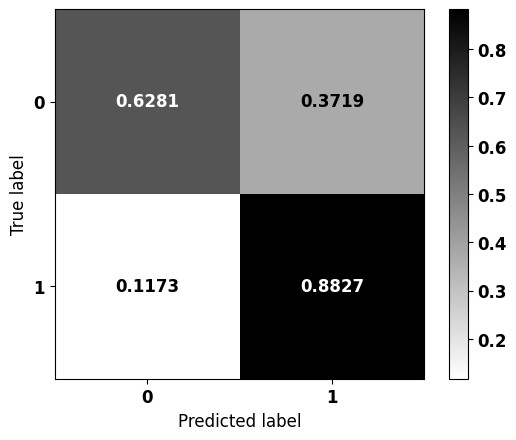


              precision    recall  f1-score   support

           0     0.8171    0.6281    0.7103      6182
           1     0.7398    0.8827    0.8050      7406

    accuracy                         0.7669     13588
   macro avg     0.7785    0.7554    0.7576     13588
weighted avg     0.7750    0.7669    0.7619     13588



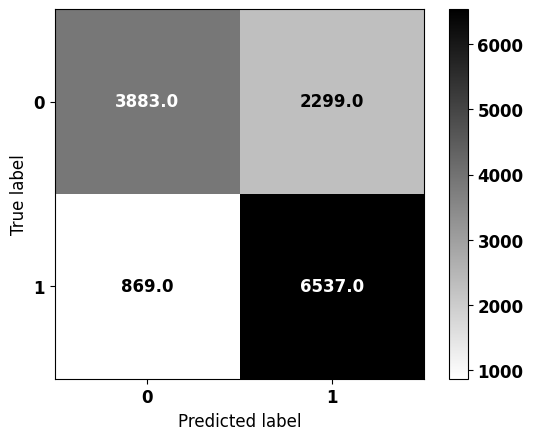


              precision    recall  f1-score   support

           0     0.8171    0.6281    0.7103      6182
           1     0.7398    0.8827    0.8050      7406

    accuracy                         0.7669     13588
   macro avg     0.7785    0.7554    0.7576     13588
weighted avg     0.7750    0.7669    0.7619     13588



In [27]:
# Colorretal
plot_confusion_matrix(best, X_test_colo, y_test_colo)
plot_confusion_matrix(best, X_test_colo, y_test_colo, norm=False)

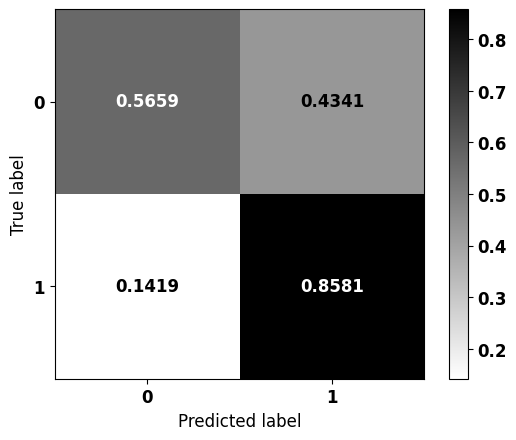


              precision    recall  f1-score   support

           0     0.7766    0.5659    0.6547       258
           1     0.6940    0.8581    0.7674       296

    accuracy                         0.7220       554
   macro avg     0.7353    0.7120    0.7110       554
weighted avg     0.7325    0.7220    0.7149       554



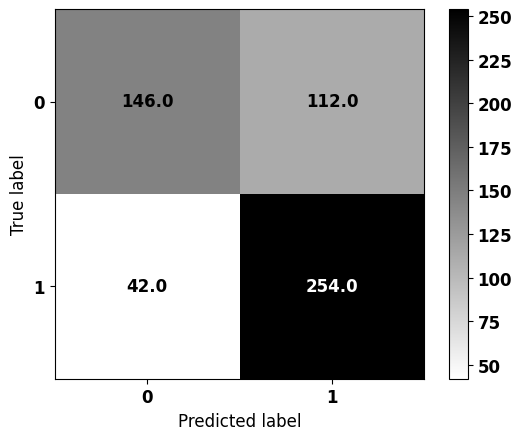


              precision    recall  f1-score   support

           0     0.7766    0.5659    0.6547       258
           1     0.6940    0.8581    0.7674       296

    accuracy                         0.7220       554
   macro avg     0.7353    0.7120    0.7110       554
weighted avg     0.7325    0.7220    0.7149       554



In [28]:
# Ânus
plot_confusion_matrix(best, X_test_anus, y_test_anus)
plot_confusion_matrix(best, X_test_anus, y_test_anus, norm=False)

### **Voting Classifier**


In [29]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7811, Optuna = 0.7847

Otimizado venceu


In [30]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7833, Optuna = 0.7853

Otimizado venceu


In [31]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1, 1: 1.3348}, colsample_bytree=0.4,
               learning_rate=0.13, max_depth=8, min_child_weight=5,
               n_estimators=146, random_state=7, verbose=-1)

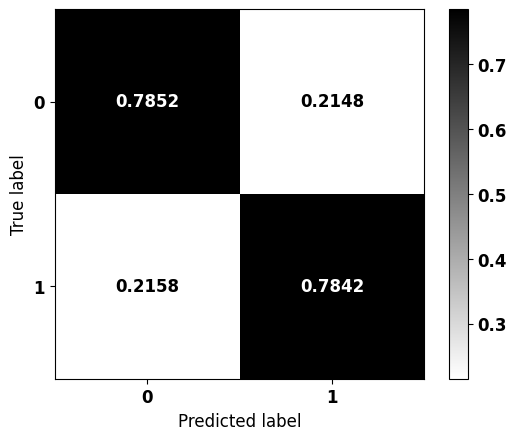


              precision    recall  f1-score   support

           0     0.8437    0.7852    0.8134     19069
           1     0.7110    0.7842    0.7458     12853

    accuracy                         0.7848     31922
   macro avg     0.7774    0.7847    0.7796     31922
weighted avg     0.7903    0.7848    0.7862     31922



In [32]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

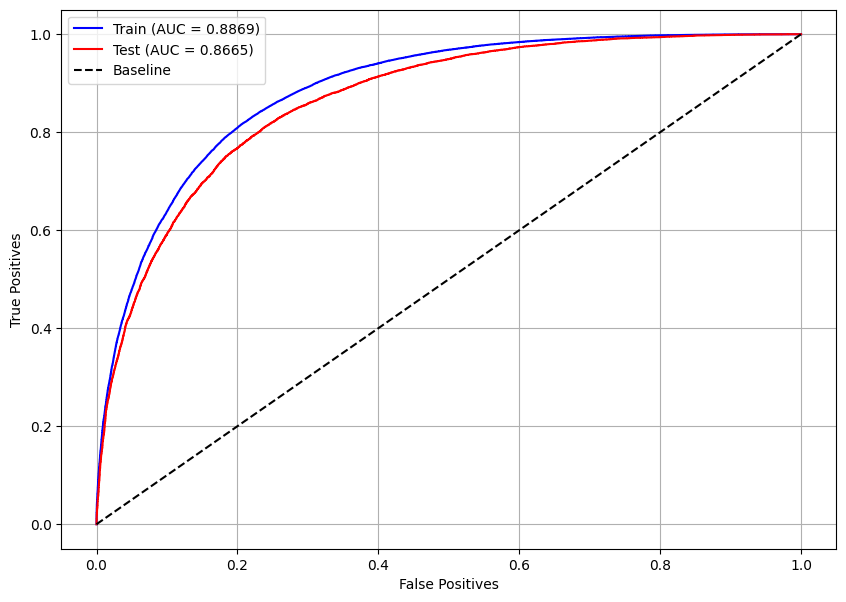

In [33]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)